In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

In [2]:
data = pd.read_csv(r"C:\Users\harri\Desktop\DataScienceProj\005_CarPurchase\EVnICE.csv")

In [3]:
data.head(10)

,Unnamed: 0,year,carType
0,0,2011,ICE
1,1,2011,ICE
2,2,2011,ICE
3,3,2011,ICE
4,4,2011,ICE
5,5,2011,ICE
6,6,2011,ICE
7,7,2011,ICE
8,8,2011,ICE
9,9,2011,ICE


In [4]:
data.drop('Unnamed: 0', inplace=True, axis=1)

In [7]:
data["year"].value_counts()

2020    4252
2013    4238
2016    4235
2018    4201
2017    4198
2019    4191
2012    4180
2015    4179
2021    4153
2014    4149
2011    4095
Name: year, dtype: int64

In [8]:
data.head()

,year,carType
0,2011,ICE
1,2011,ICE
2,2011,ICE
3,2011,ICE
4,2011,ICE


In [9]:
data.groupby(["year"], as_index=False).count()

,year,carType
0,2011,4095
1,2012,4180
2,2013,4238
3,2014,4149
4,2015,4179
5,2016,4235
6,2017,4198
7,2018,4201
8,2019,4191
9,2020,4252


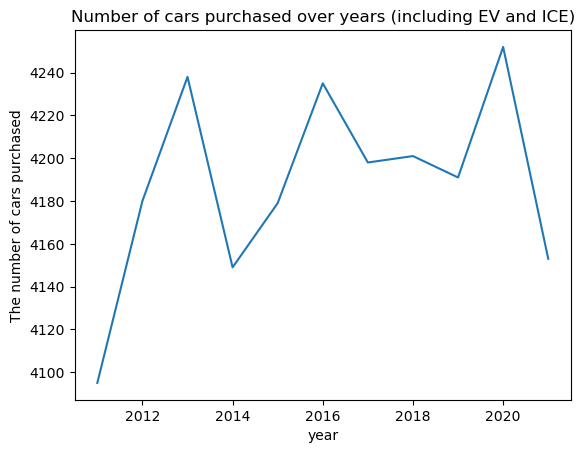

In [11]:
plt.title('Number of cars purchased over years (including EV and ICE)')
plt.xlabel('year')
plt.ylabel('The number of cars purchased')
sns.lineplot(data=data.groupby(["year"], as_index=False).count(),x='year', y='carType')
plt.show()

**ICE**

In [14]:
ice = data.query('carType == "ICE"').groupby(["year"], as_index=False).count()
ice.rename(columns={"carType": "count"}, inplace=True)
ice


,year,count
0,2011,4092
1,2012,4170
2,2013,4217
3,2014,4098
4,2015,4126
5,2016,4164
6,2017,4139
7,2018,4149
8,2019,4093
9,2020,4142


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

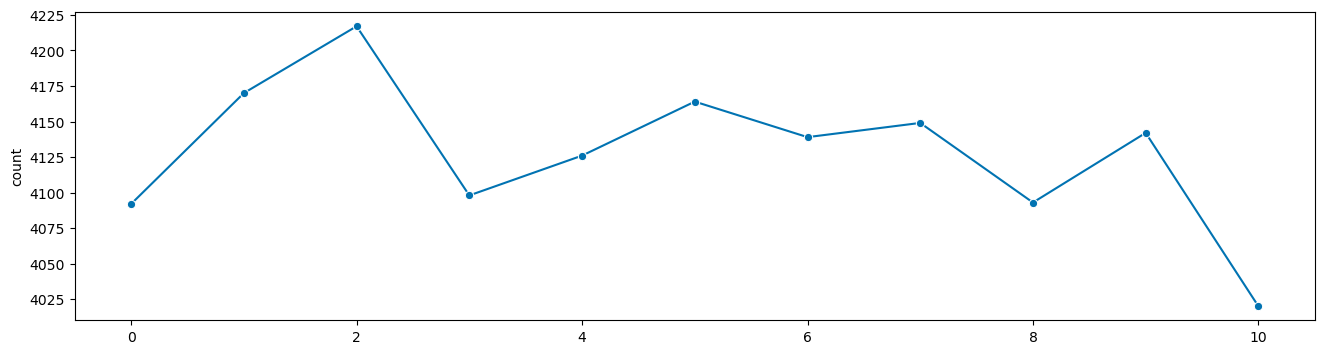

In [15]:
plot_series(ice["count"])

C:\Users\harri\AppData\Local\Temp\ipykernel_27088\2205618768.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Text(0.5, 1.0, 'Time Plot of ICE Car Sales')

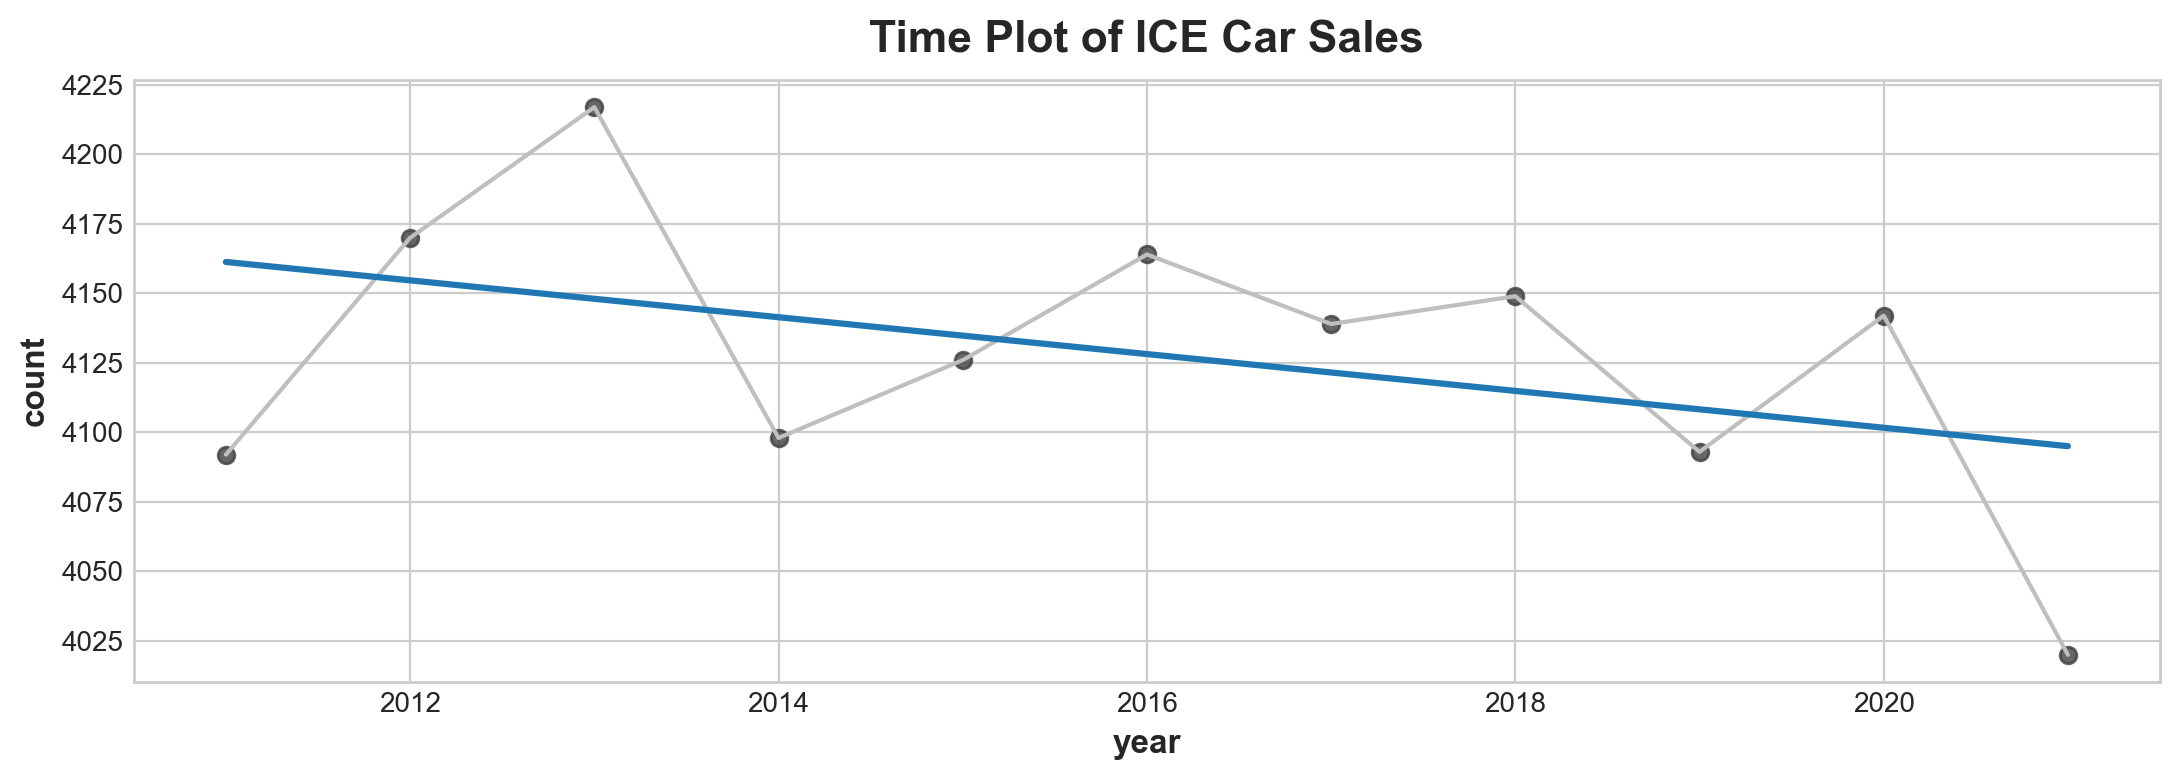

In [16]:

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('year', 'count', data=ice, color='0.75')
ax = sns.regplot(x='year', y='count', data=ice, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of ICE Car Sales')

In [17]:
ice['Lag_1'] = ice['count'].shift(1)
df = ice.reindex(columns=['count', 'Lag_1'])

df.head()

,count,Lag_1
0,4092,NaN
1,4170,4092.0
2,4217,4170.0
3,4098,4217.0
4,4126,4098.0


In [18]:
ice.head()

,year,count,Lag_1
0,2011,4092,NaN
1,2012,4170,4092.0
2,2013,4217,4170.0
3,2014,4098,4217.0
4,2015,4126,4098.0


Text(0.5, 1.0, 'Lag Plot of ICE Car Sales')

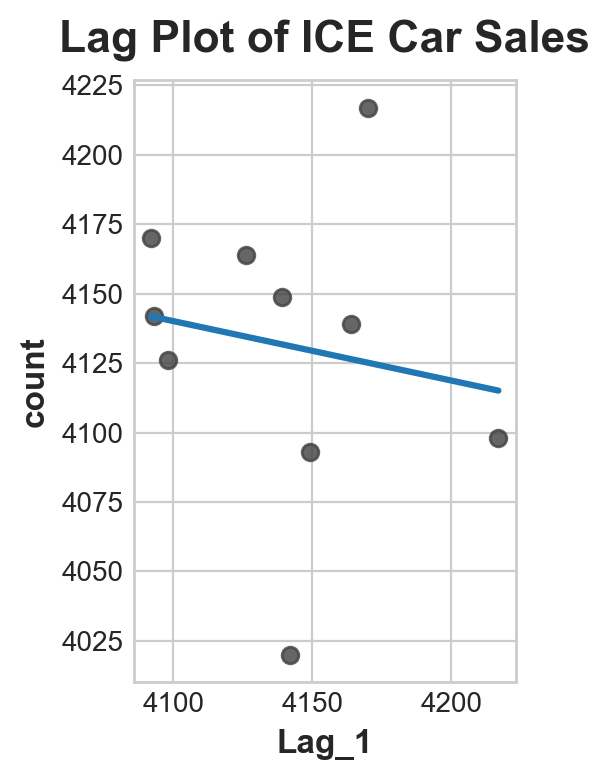

In [19]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='count', data=ice, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of ICE Car Sales')

From the lag plot, ice car purchase sale does not show a significant correlation with previous year (lag_1) because it shows slight decrease on previous year may contribute small effect on the next year purchase

https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

Univariate Statistical Method ARIMA


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [24]:
ice = data.query('carType == "ICE"').groupby(["year"], as_index=False).count()
ice.rename(columns={"carType": "count"}, inplace=True)
ice

,year,count
0,2011,4092
1,2012,4170
2,2013,4217
3,2014,4098
4,2015,4126
5,2016,4164
6,2017,4139
7,2018,4149
8,2019,4093
9,2020,4142


In [25]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [26]:
test_split = 0.2
ice_train, ice_test = split_data(ice, test_split)

train: 9 , test: 2


In [27]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \tlags:{results[1]}")
    return (s, results[0])

In [28]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c}score: {initial_score}')
    return score[best_model]['model']

In [29]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [30]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

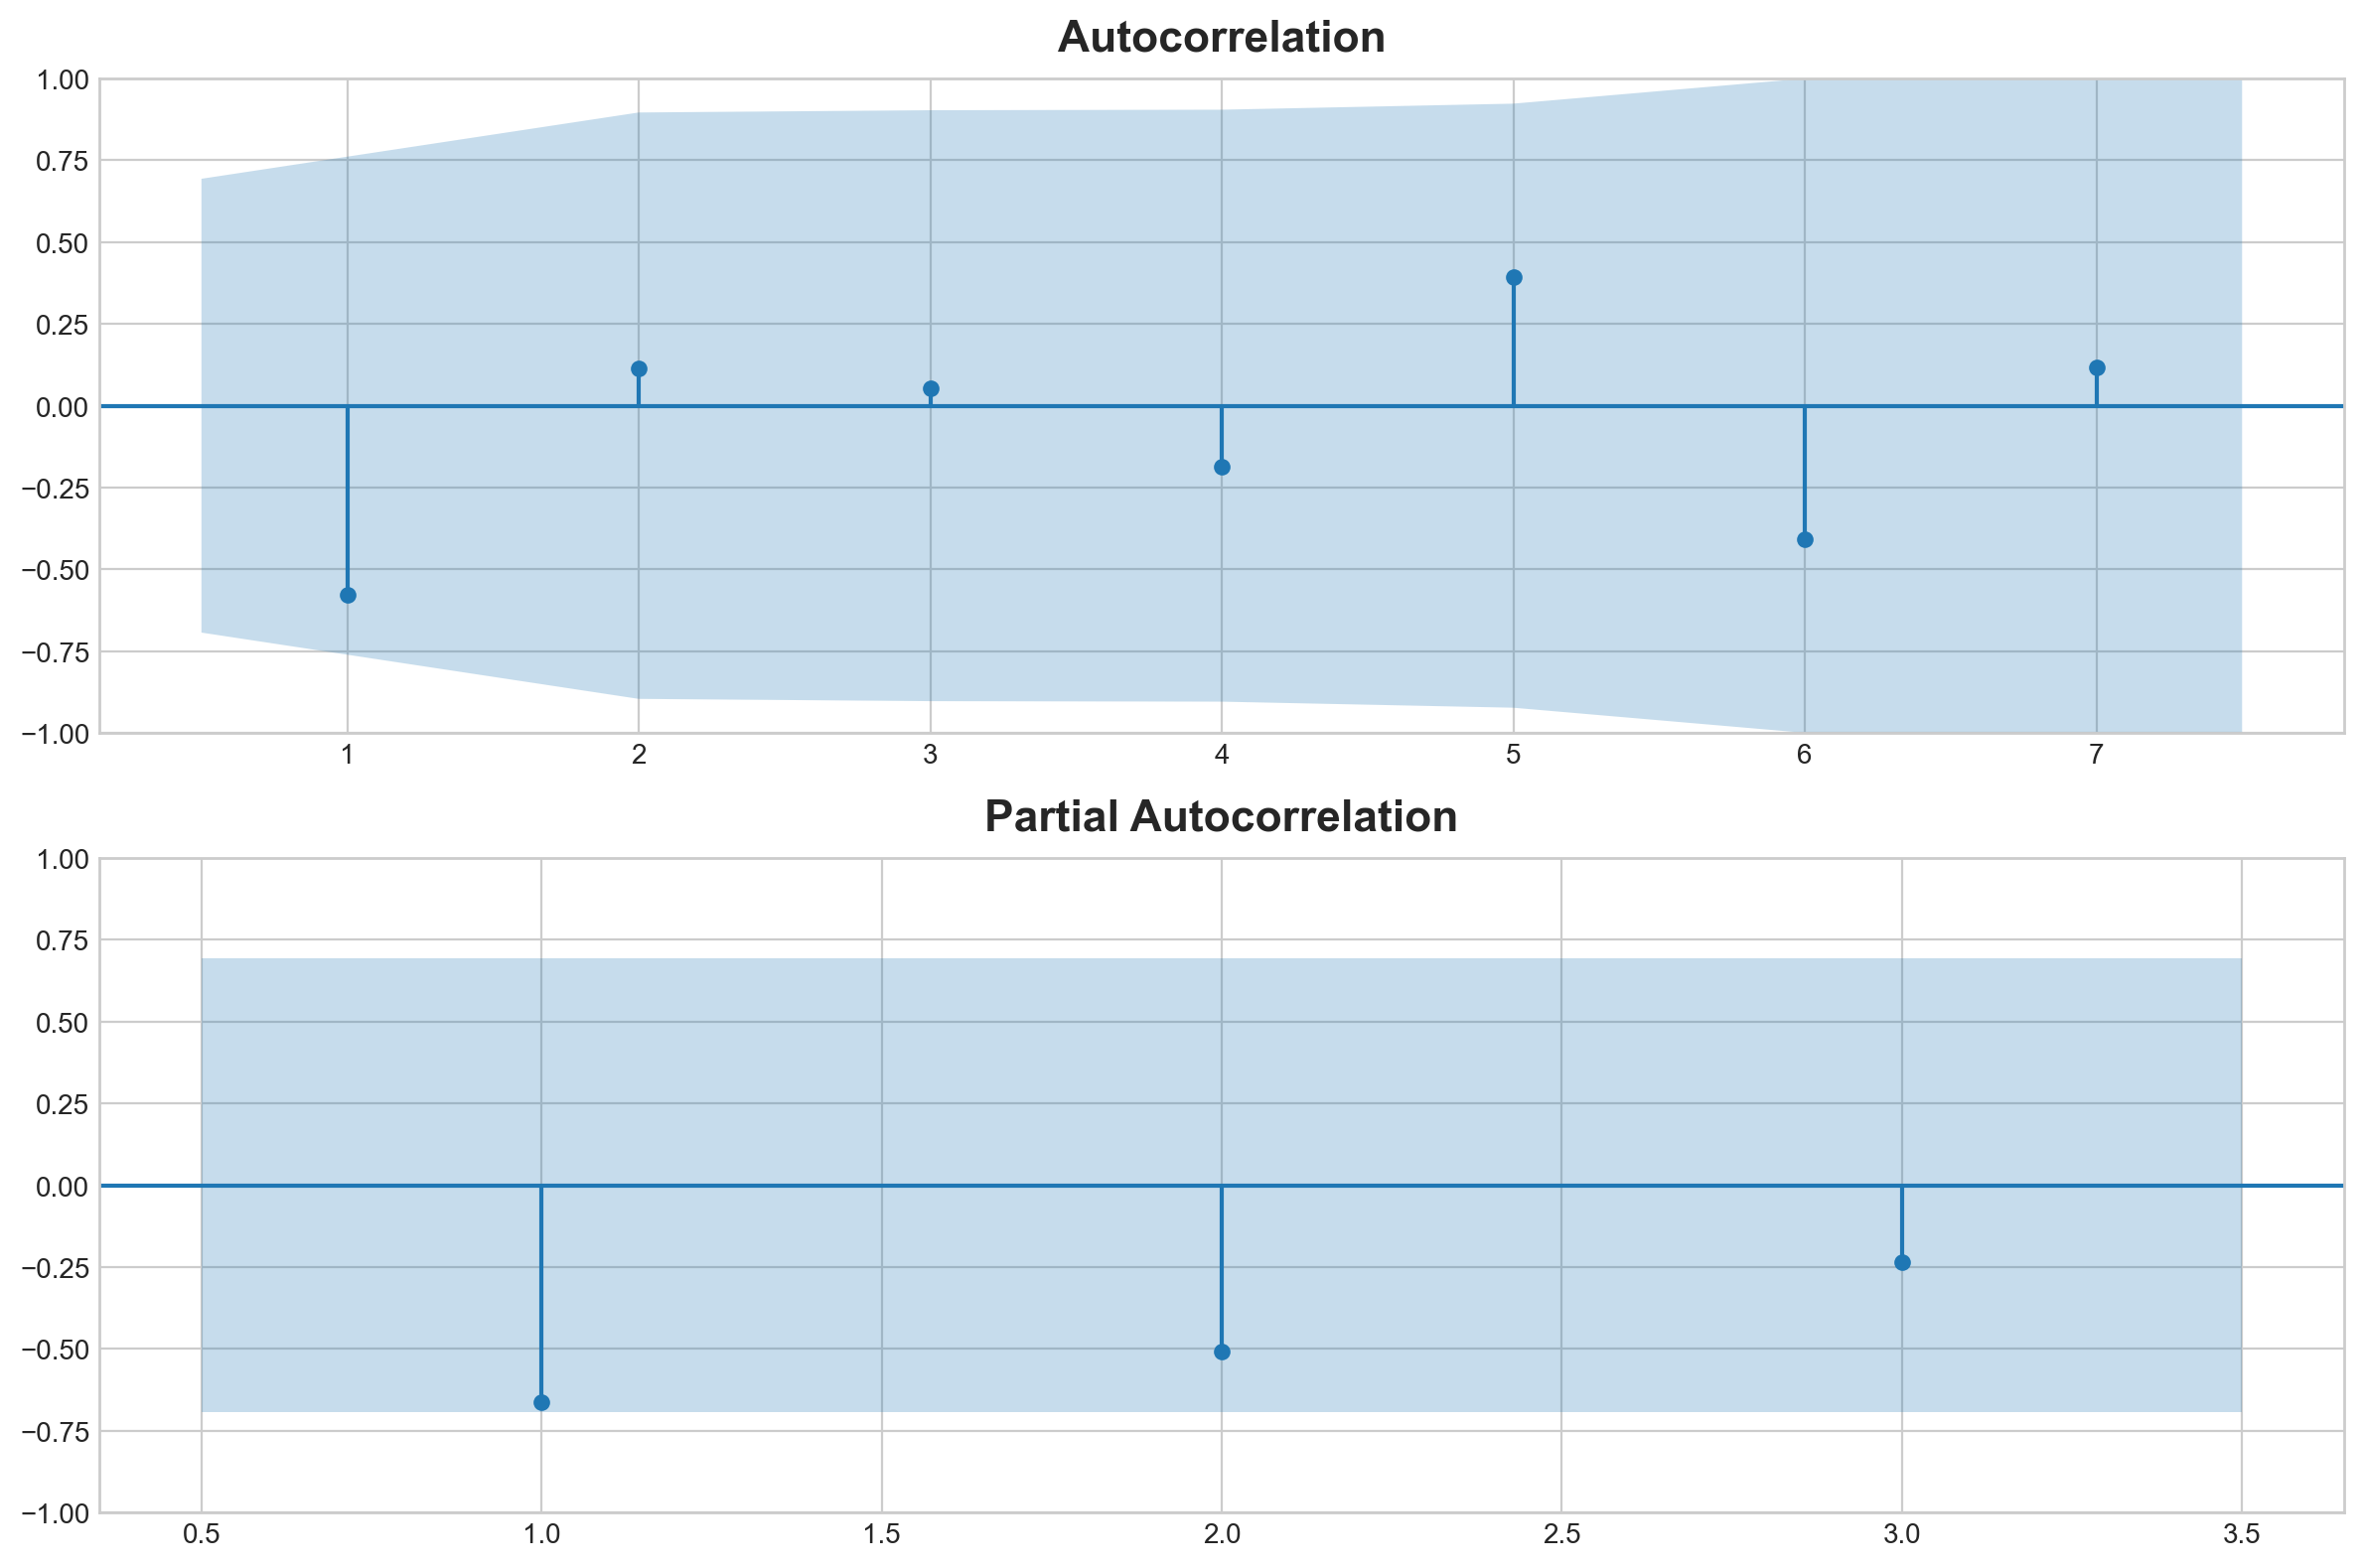

In [31]:
ice_diff = ice.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(ice_diff["count"].diff().diff().dropna(), zero=False, ax=ax[0])
plot_pacf(ice_diff["count"].diff().diff().dropna(), zero=False, lags=3,ax=ax[1])
plt.show()

In [32]:
ice_diff["count"].head()

1     78.0
2     47.0
3   -119.0
4     28.0
5     38.0
Name: count, dtype: float64

In [61]:
check_stationarity(ice_diff["count"].diff().diff().dropna()) #requre 2order of differencing

'Stationary	 p-value:0.008371247446485154 	lags:2


('Stationary', 0.008371247446485154)

In [33]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [34]:
ice.head()

,year,count
0,2011,4092
1,2012,4170
2,2013,4217
3,2014,4098
4,2015,4126


In [35]:
model = ARIMA(ice["count"], order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                   11
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -54.945
Date:                Wed, 01 Feb 2023   AIC                            113.890
Time:                        09:48:34   BIC                            114.495
Sample:                             0   HQIC                           113.226
                                 - 11                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7622      0.925     -0.824      0.410      -2.576       1.051
sigma2      3049.7652   1656.654      1.841      0.066    -197.217    6296.748
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.92   Prob(JB):                         0.89
Heteroskedasticity (H):               1.05   Skew:                            -0.26
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(ice["count"], order=(p,d,q))
    res = m.fit()
    y = ice["count"].values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic,
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AICscore: 108.6117184404062


In [37]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,8,"(0, 2, 2)",108.611718,0.574748,109.203392,113.411718,237.287391,0.05332,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,7,"(0, 2, 1)",109.271308,0.480061,109.665758,111.271308,198.814673,0.046501,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,15,"(1, 2, 0)",110.525343,1.164837,110.919792,112.525343,479.78547,0.108159,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,16,"(1, 2, 1)",110.661851,0.282833,111.253525,115.461851,117.619649,0.02607,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,24,"(2, 2, 0)",111.274532,0.908899,111.866206,116.074532,374.738927,0.085238,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,6,"(0, 2, 0)",111.385981,2.22978,111.583206,111.95741,917.068055,0.203888,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,25,"(2, 2, 1)",111.703789,0.273123,112.492687,121.703789,113.602959,0.024814,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,26,"(2, 2, 2)",113.85583,0.193267,114.841953,133.85583,80.537677,0.016705,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,4,"(0, 1, 1)",113.89007,0.129646,114.495241,115.604356,53.730484,0.01061,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,3,"(0, 1, 0)",114.679427,0.28577,114.982012,115.179427,118.920906,0.026066,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


AUTORIMA

In [80]:
import pmdarima as pm

In [81]:
from sklearn.model_selection import train_test_split
train_ice, test_ice = train_test_split(ice, test_size=0.10, shuffle=False)

In [86]:
auto_model = pm.auto_arima(train_ice["count"].diff().diff().dropna(),seasonal=False,m=2,test='adf',stepwise=True, trace=True)
auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=85.232, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=86.166, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=86.925, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.111 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    7
Model:                        SARIMAX   Log Likelihood                 -41.616
Date:                Mon, 30 Jan 2023   AIC                             85.232
Time:                        20:42:04   BIC                             85.178
Sample:                             0   HQIC                            84.564
                                  - 7                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8539.4286   5314.871      1.607      0.108   -1877.527     1.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.17   Prob(JB):                         0.94
Heteroskedasticity (H):               0.20   Skew:                             0.27
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MACHINE LEARNING

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [39]:
data = pd.read_csv(r"C:\Users\harri\Desktop\DataScienceProj\005_CarPurchase\EVnICE.csv", index_col="year")

In [40]:
data.head()

,Unnamed: 0,carType
year,,
2011,0,ICE
2011,1,ICE
2011,2,ICE
2011,3,ICE
2011,4,ICE


In [41]:
data.drop('Unnamed: 0', inplace=True, axis=1)

In [42]:
data.head()

,carType
year,
2011,ICE
2011,ICE
2011,ICE
2011,ICE
2011,ICE


In [43]:
data =data.groupby(["year"], as_index=True).count()

In [44]:
data.head()

,carType
year,
2011,4095
2012,4180
2013,4238
2014,4149
2015,4179


In [45]:
data.columns = ["y"]

In [46]:
data.index

Int64Index([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='int64', name='year')

<AxesSubplot: title={'center': 'ICE Car purchase'}, xlabel='year'>

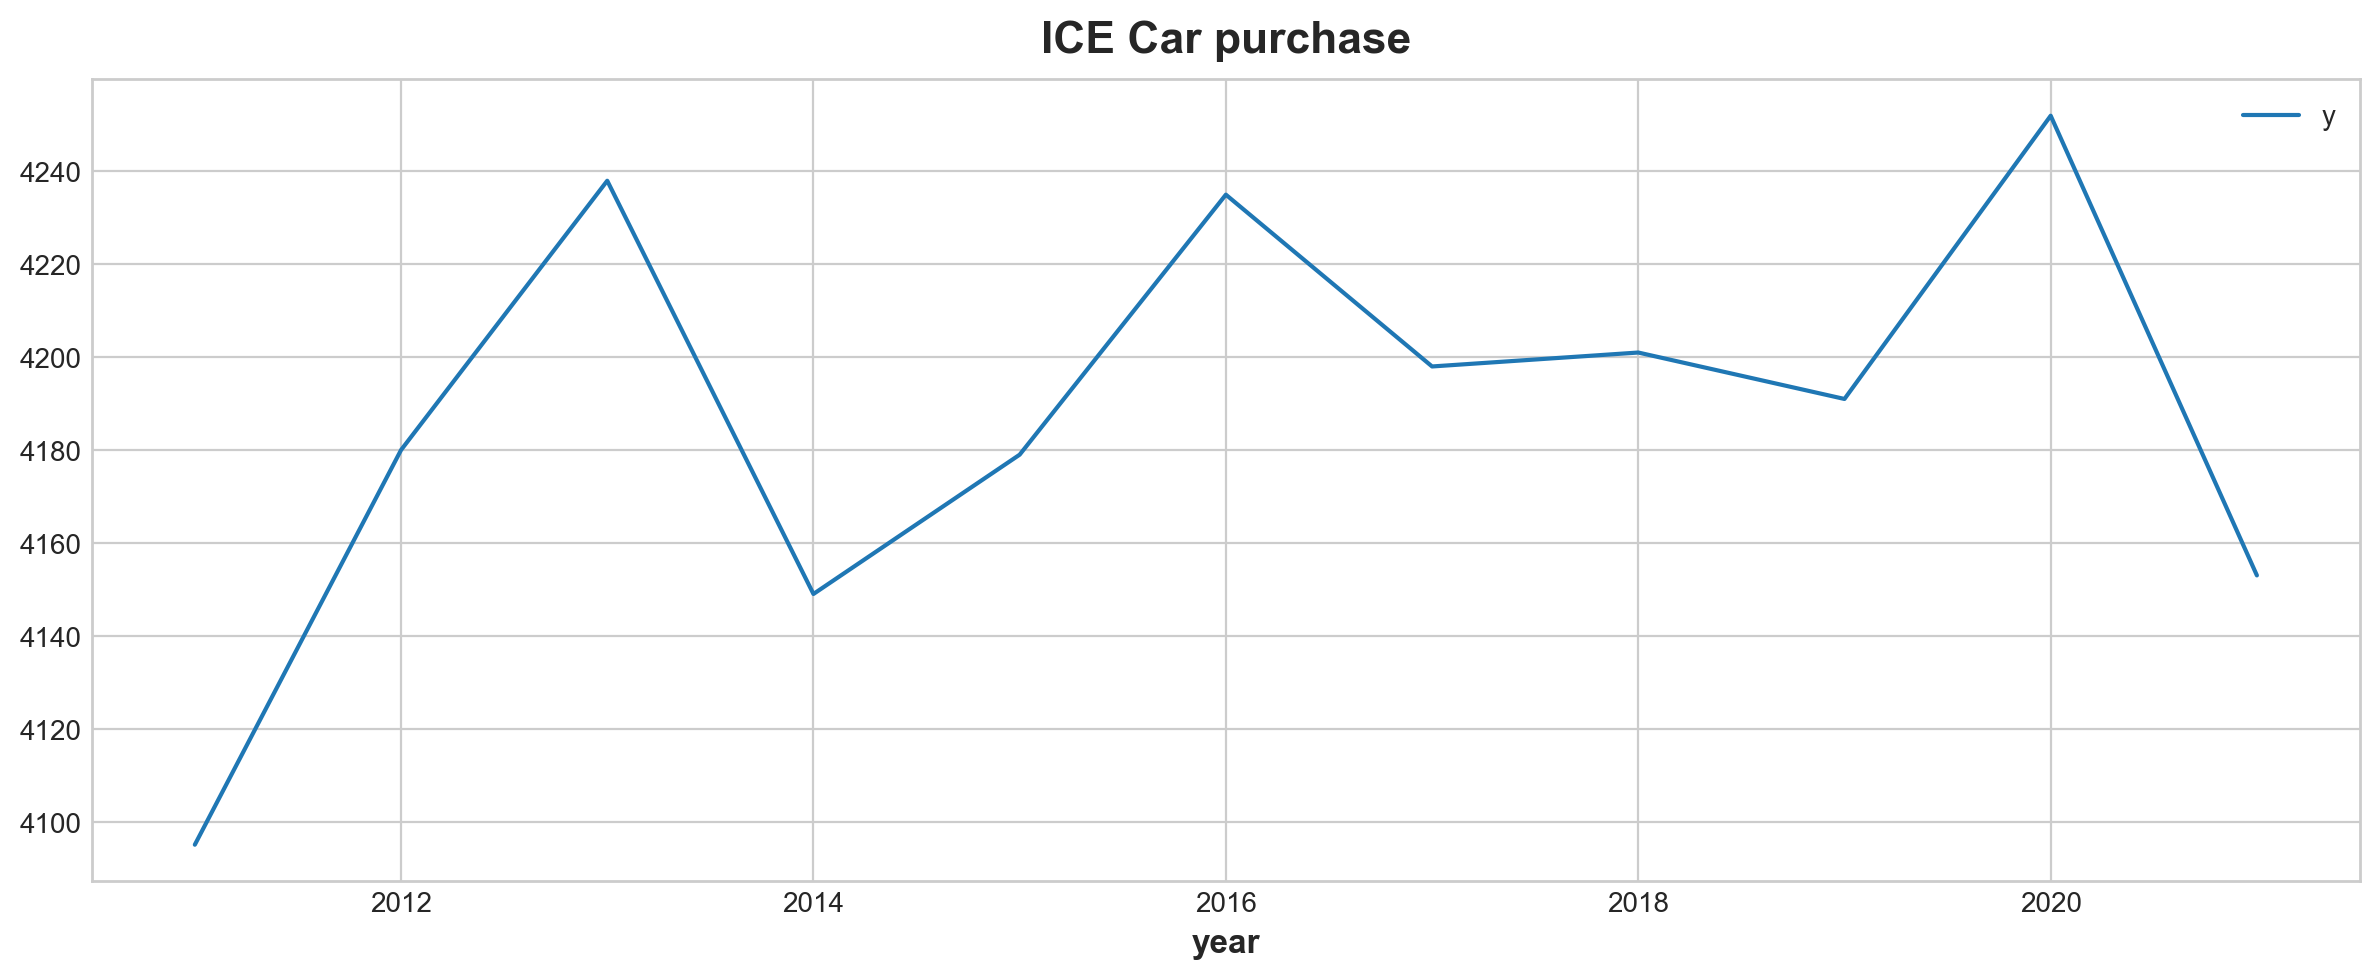

In [47]:
data.plot(title='ICE Car purchase')

In [48]:
ice = data.copy()

In [49]:
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

In [50]:
def split_data(df, test_split=0.25):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

In [51]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]

In [52]:
def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

In [53]:
def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results

In [54]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()

In [55]:
from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

mse = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()

In [56]:
ice.head()

,y
year,
2011,4095
2012,4180
2013,4238
2014,4149
2015,4179


In [57]:
ice_os = one_step_forecast(ice, 3)
print(ice_os.shape)

(8, 4)


In [58]:
ice_os.head()

,x_1,x_2,x_3,y
year,,,,
2011,4095,4180,4238,4149
2012,4180,4238,4149,4179
2013,4238,4149,4179,4235
2014,4149,4179,4235,4198
2015,4179,4235,4198,4201


In [59]:
train, test = split_data(ice_os)
print(f'Train: {len(train)} Test: {len(test)}')

Train: 6 Test: 2


In [60]:
scaler = Standardize()
train_s, test_s = scaler.fit_transform(train, test)
train_s.head()

,x_1,x_2,x_3,y
year,,,,
2011,-1.562086,-0.474675,1.123887,-1.529074
2012,0.012349,1.193880,-1.508374,-0.466397
2013,1.086668,-1.366489,-0.621095,1.517266
2014,-0.561857,-0.503443,1.035159,0.206632
2015,-0.006174,1.107576,-0.059152,0.312899


In [61]:
y_train_original = scaler.inverse_y(train_s['y'])

In [62]:
train_original = scaler.inverse(train_s)
train_original.head()

,x_1,x_2,x_3,y
year,,,,
2011,4095.0,4180.0,4238.0,4149.0
2012,4180.0,4238.0,4149.0,4179.0
2013,4238.0,4149.0,4179.0,4235.0
2014,4149.0,4179.0,4235.0,4198.0
2015,4179.0,4235.0,4198.0,4201.0


In [63]:
from sklearn.linear_model import( LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor)

In [64]:
train_s.head()

,x_1,x_2,x_3,y
year,,,,
2011,-1.562086,-0.474675,1.123887,-1.529074
2012,0.012349,1.193880,-1.508374,-0.466397
2013,1.086668,-1.366489,-0.621095,1.517266
2014,-0.561857,-0.503443,1.035159,0.206632
2015,-0.006174,1.107576,-0.059152,0.312899


In [65]:
test_s.head()

,x_1,x_2,x_3,y
year,,,,
2017,0.345758,0.129457,-0.266184,2.119450
2018,0.401326,-0.158225,1.537950,-1.387384


In [66]:
regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}

In [67]:
ice_results = train_different_models(train_s, test_s, regressors)

training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [68]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
ice_results = pd.DataFrame(ice_results)
ice_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
2,Ridge Regression,1.749553,1.016578,1.806925
3,Lasso Regression,1.783829,1.010985,1.824876
1,Elastic Net,1.778780,1.023194,1.830706
0,Linear Regression,1.788909,1.051100,1.853209
4,Huber Regression,1.883433,1.125011,1.954728


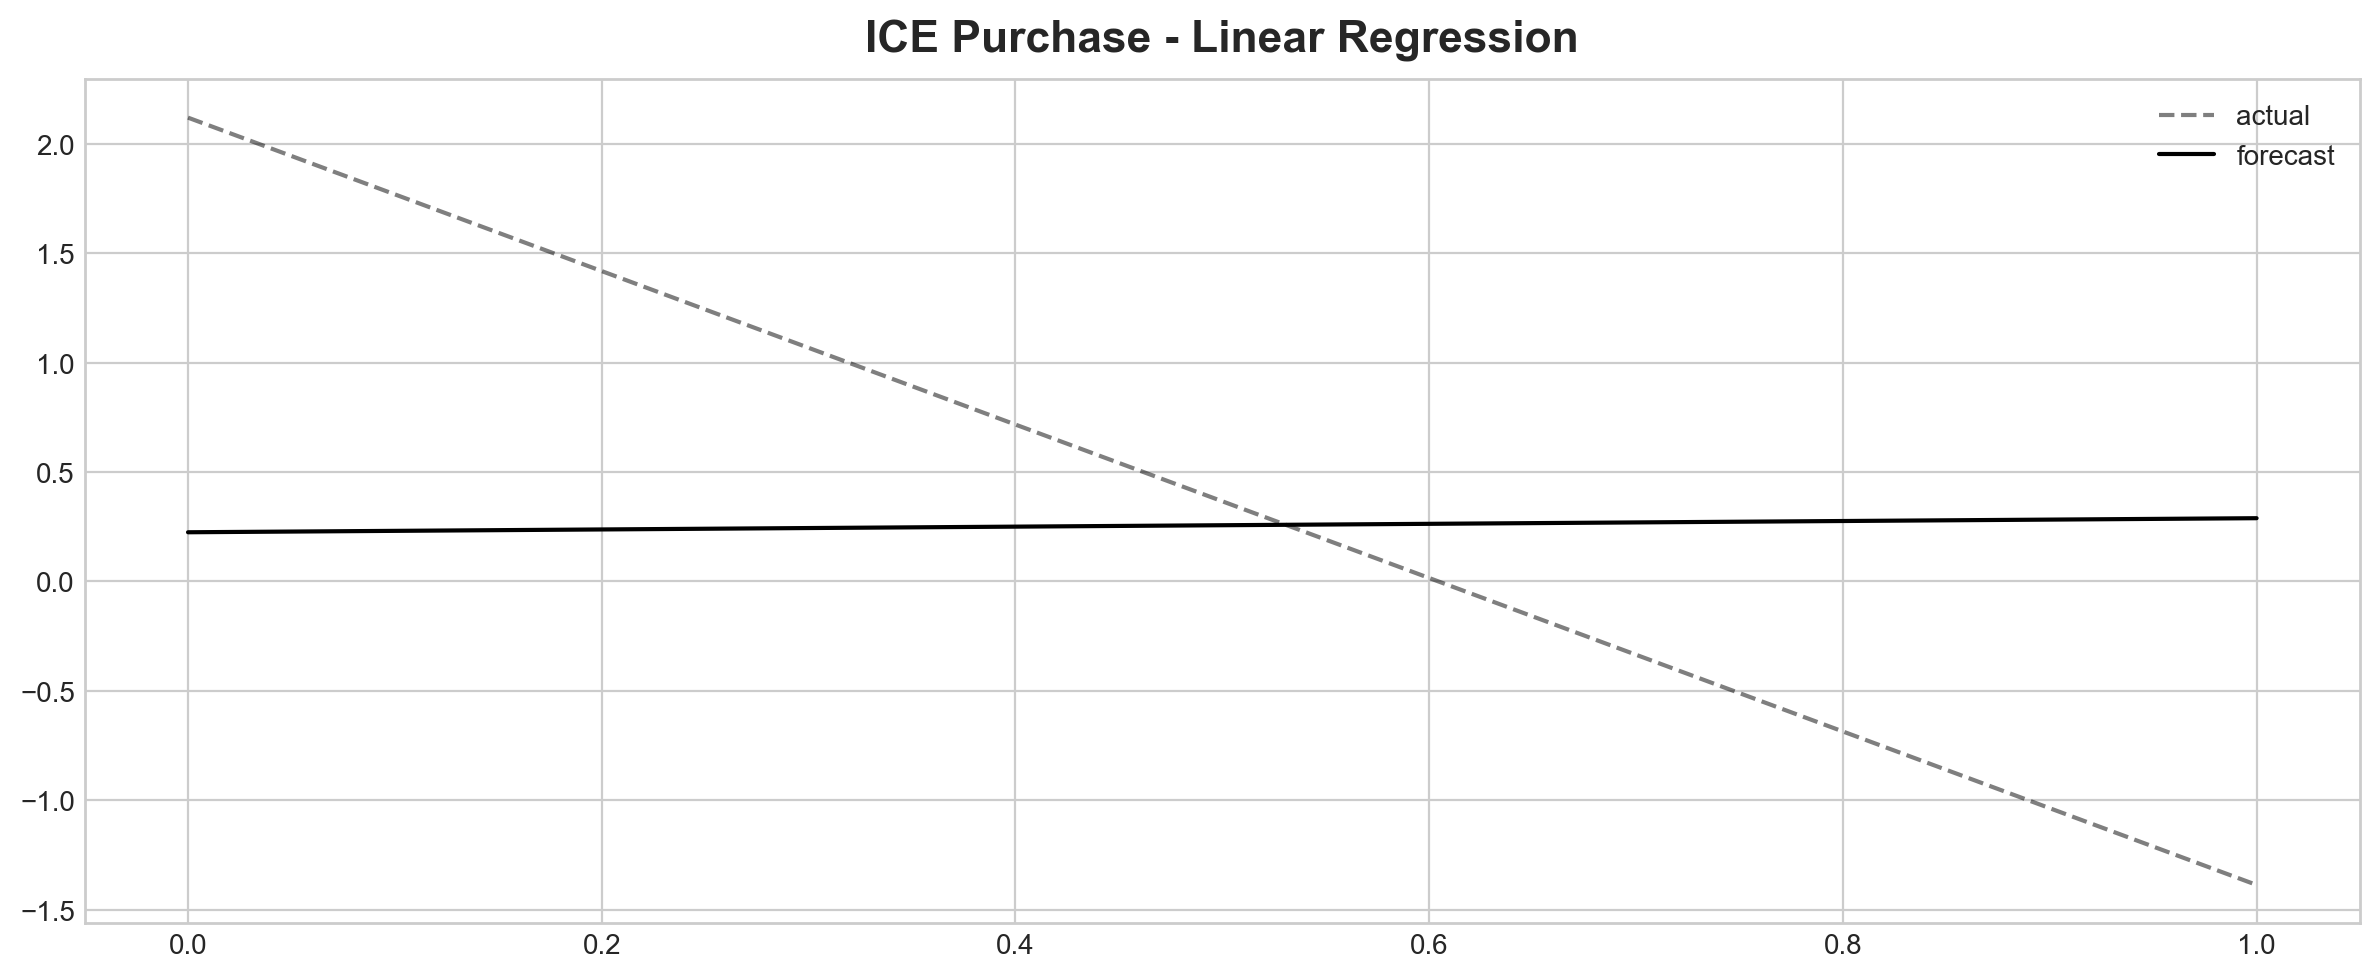

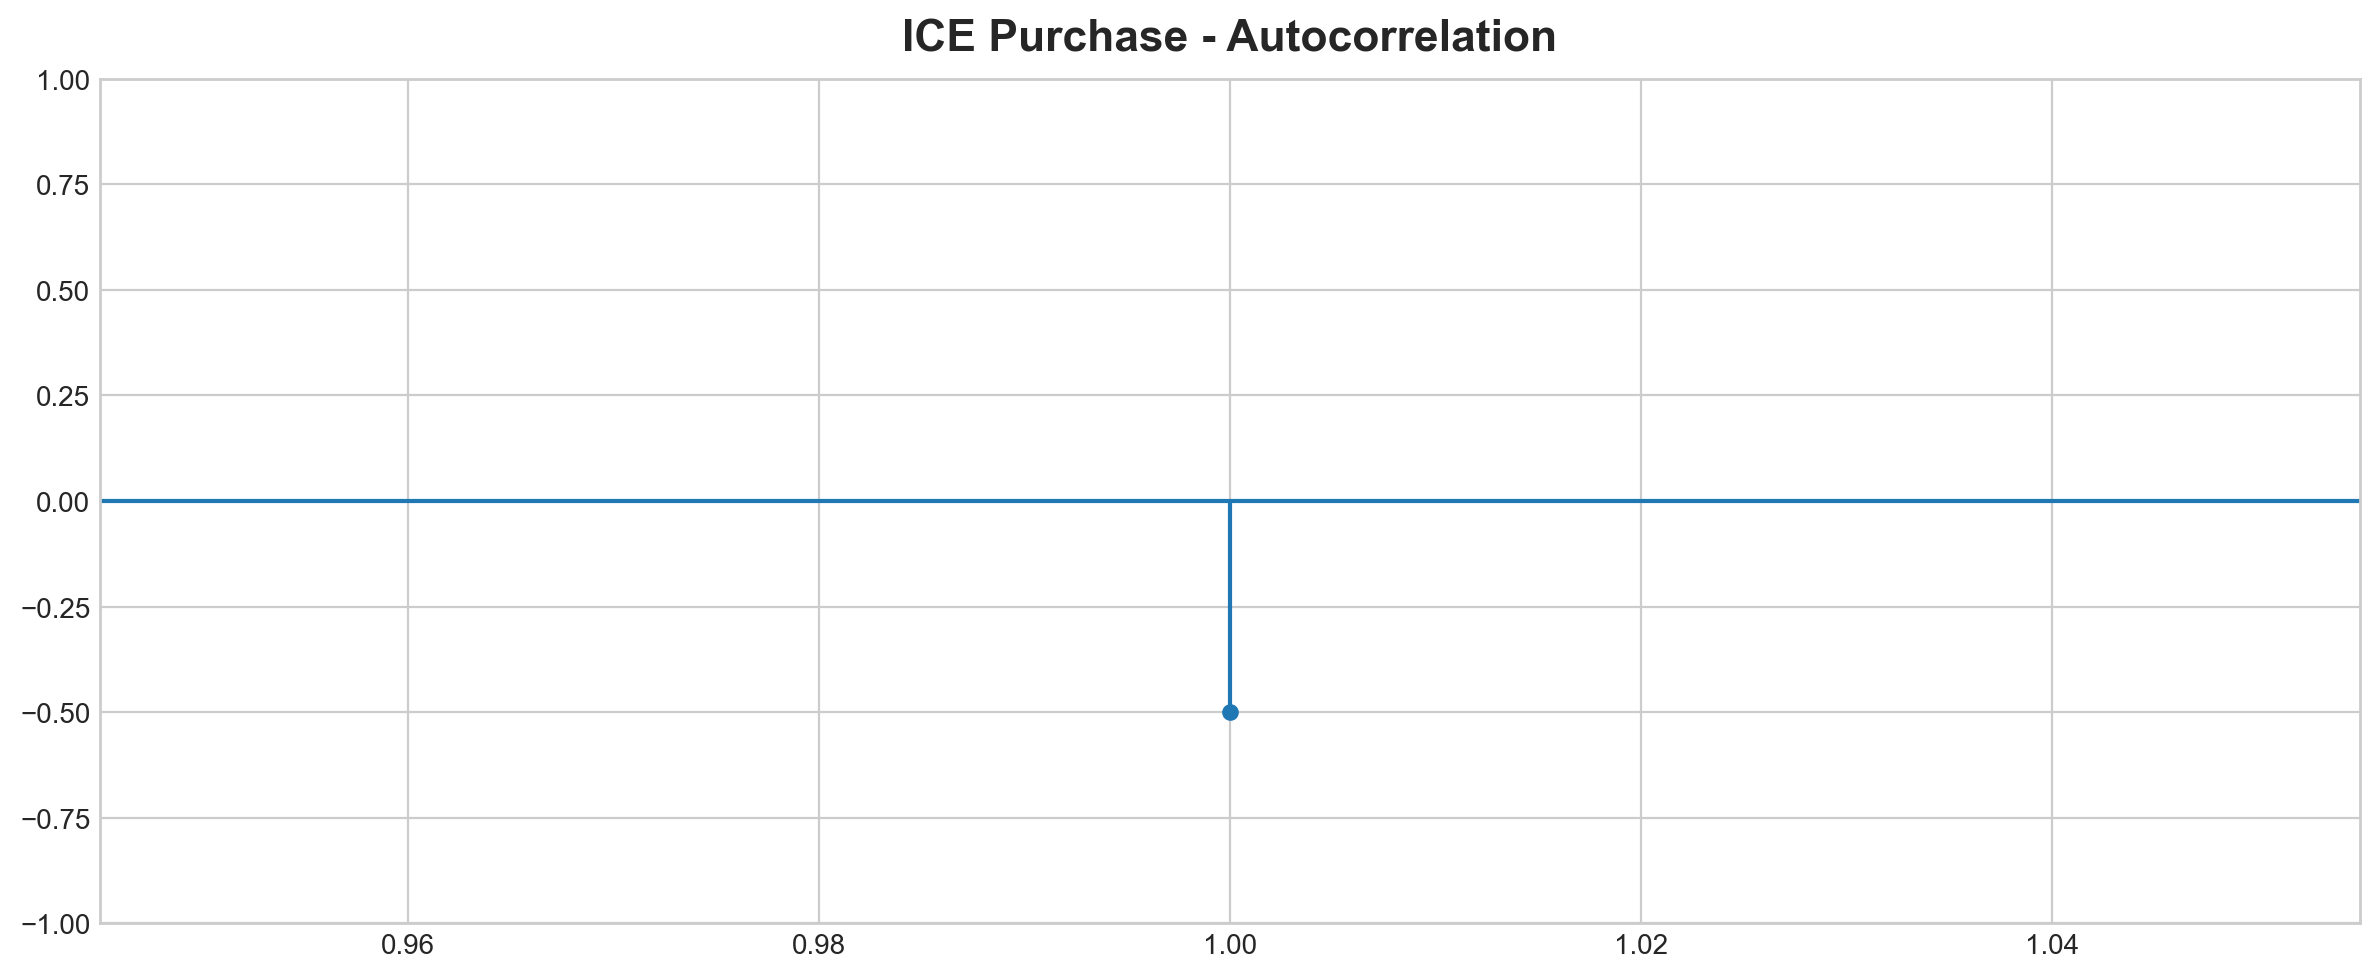

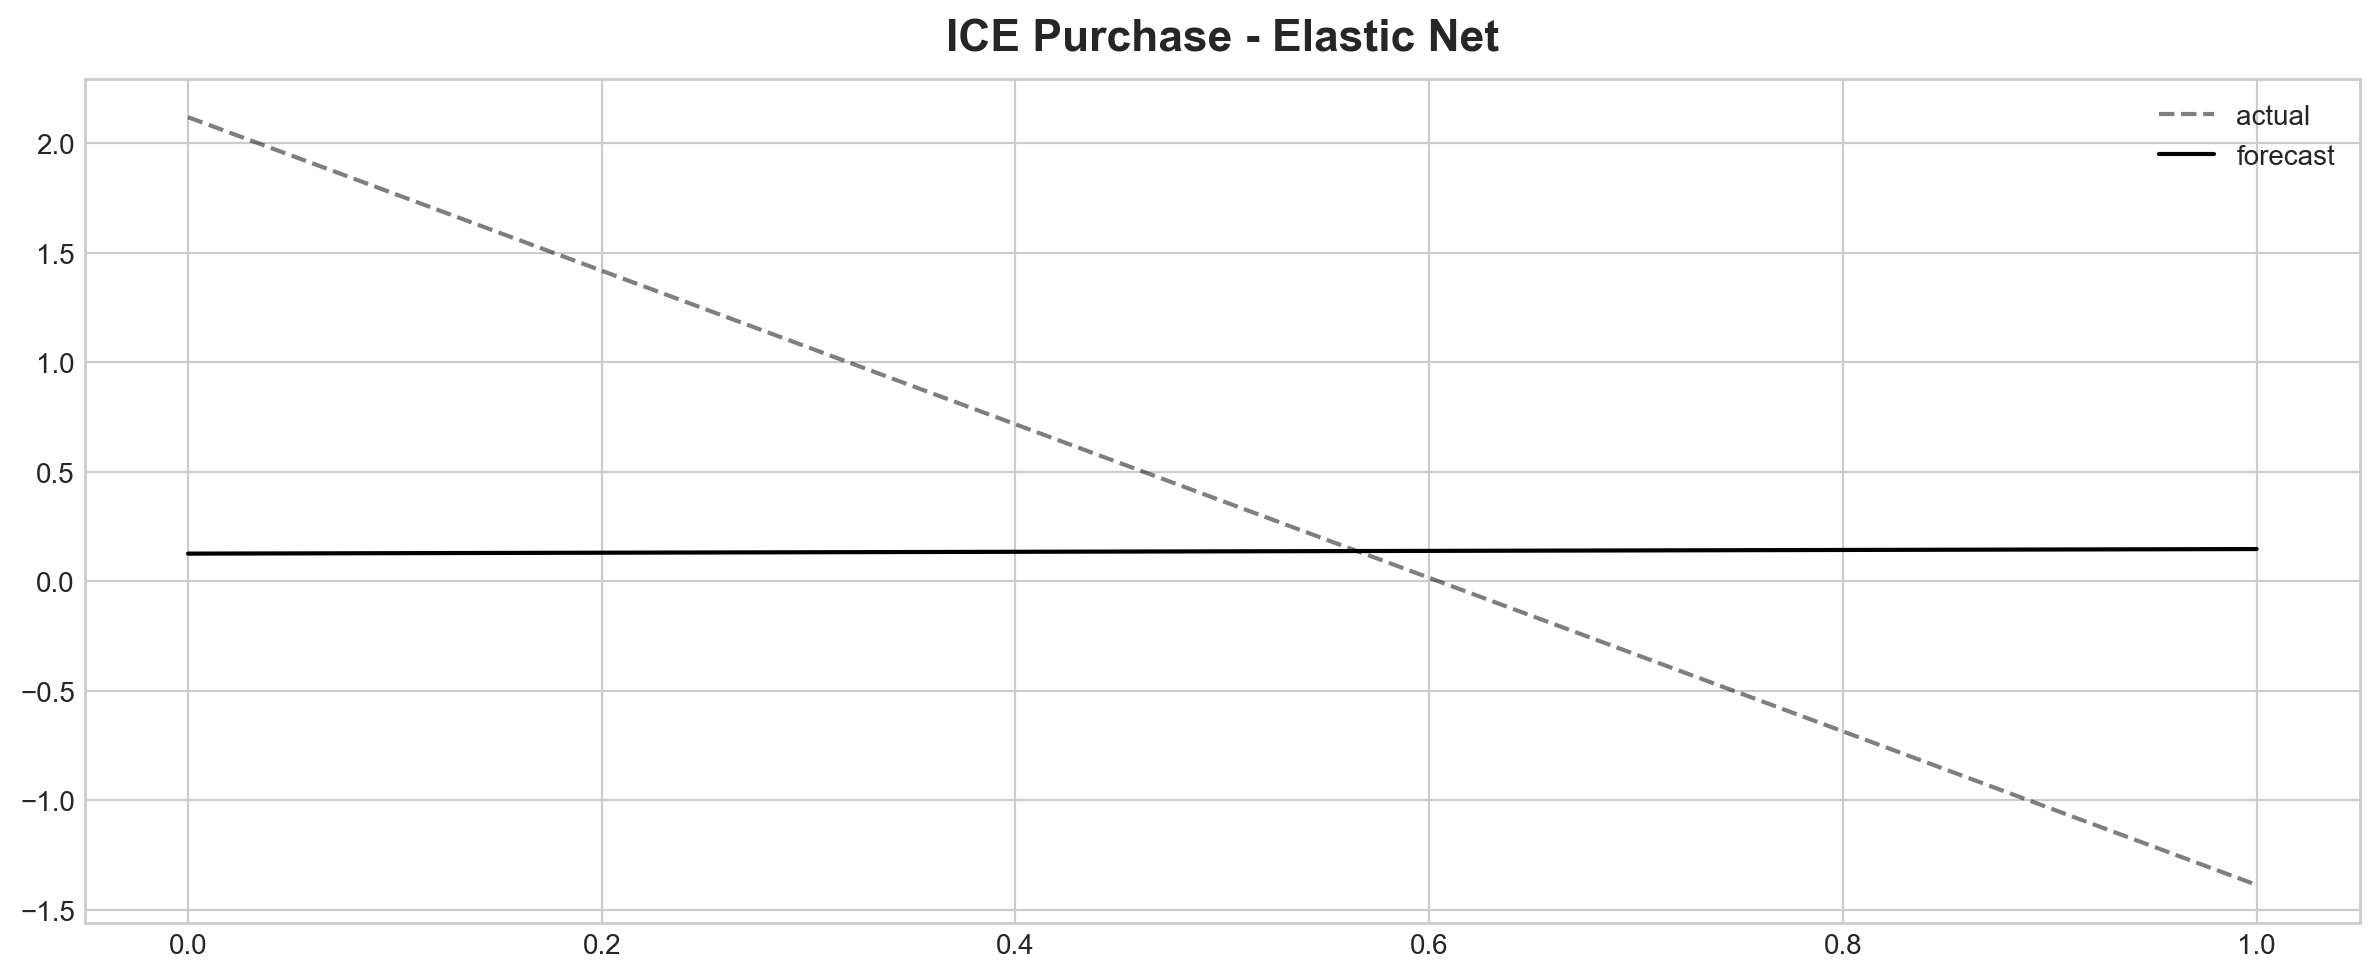

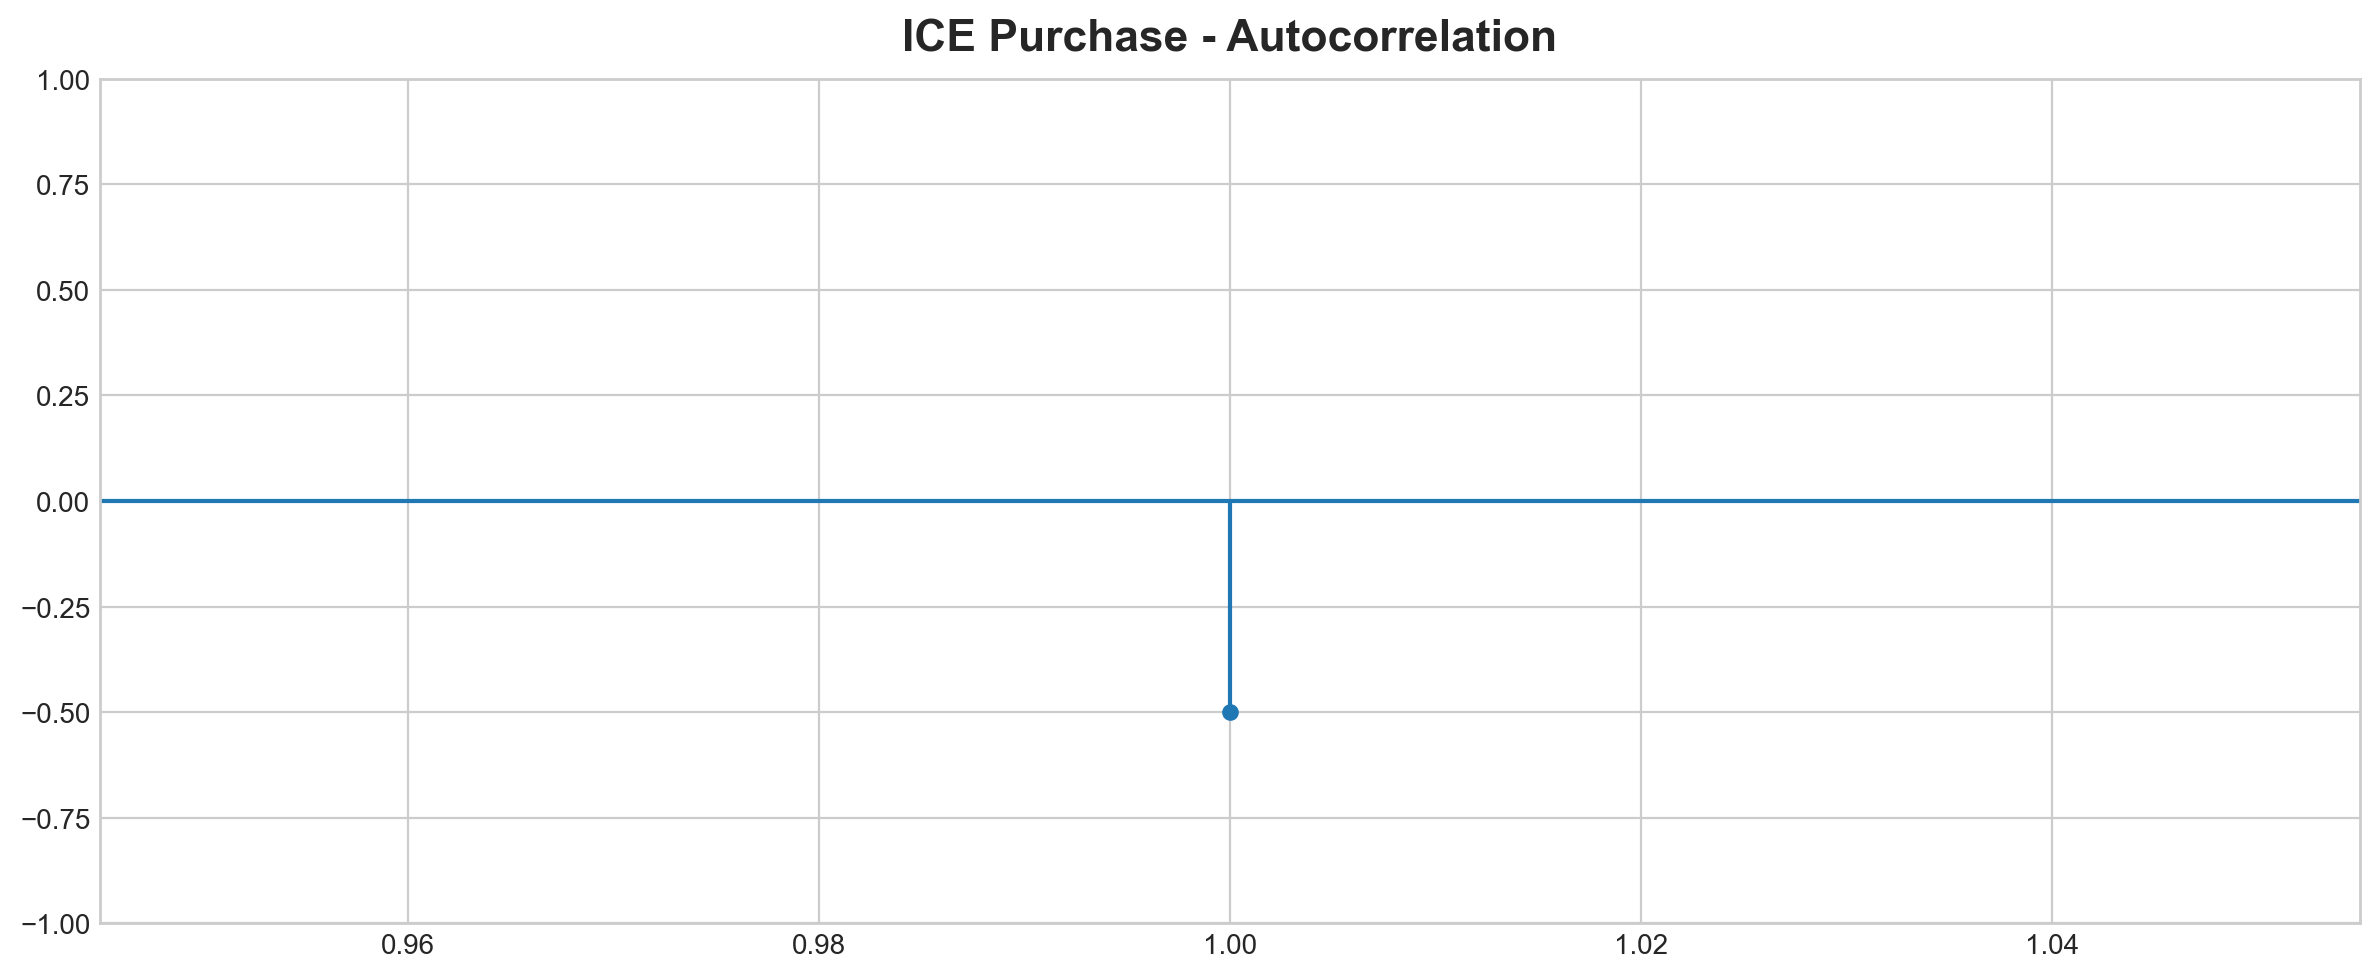

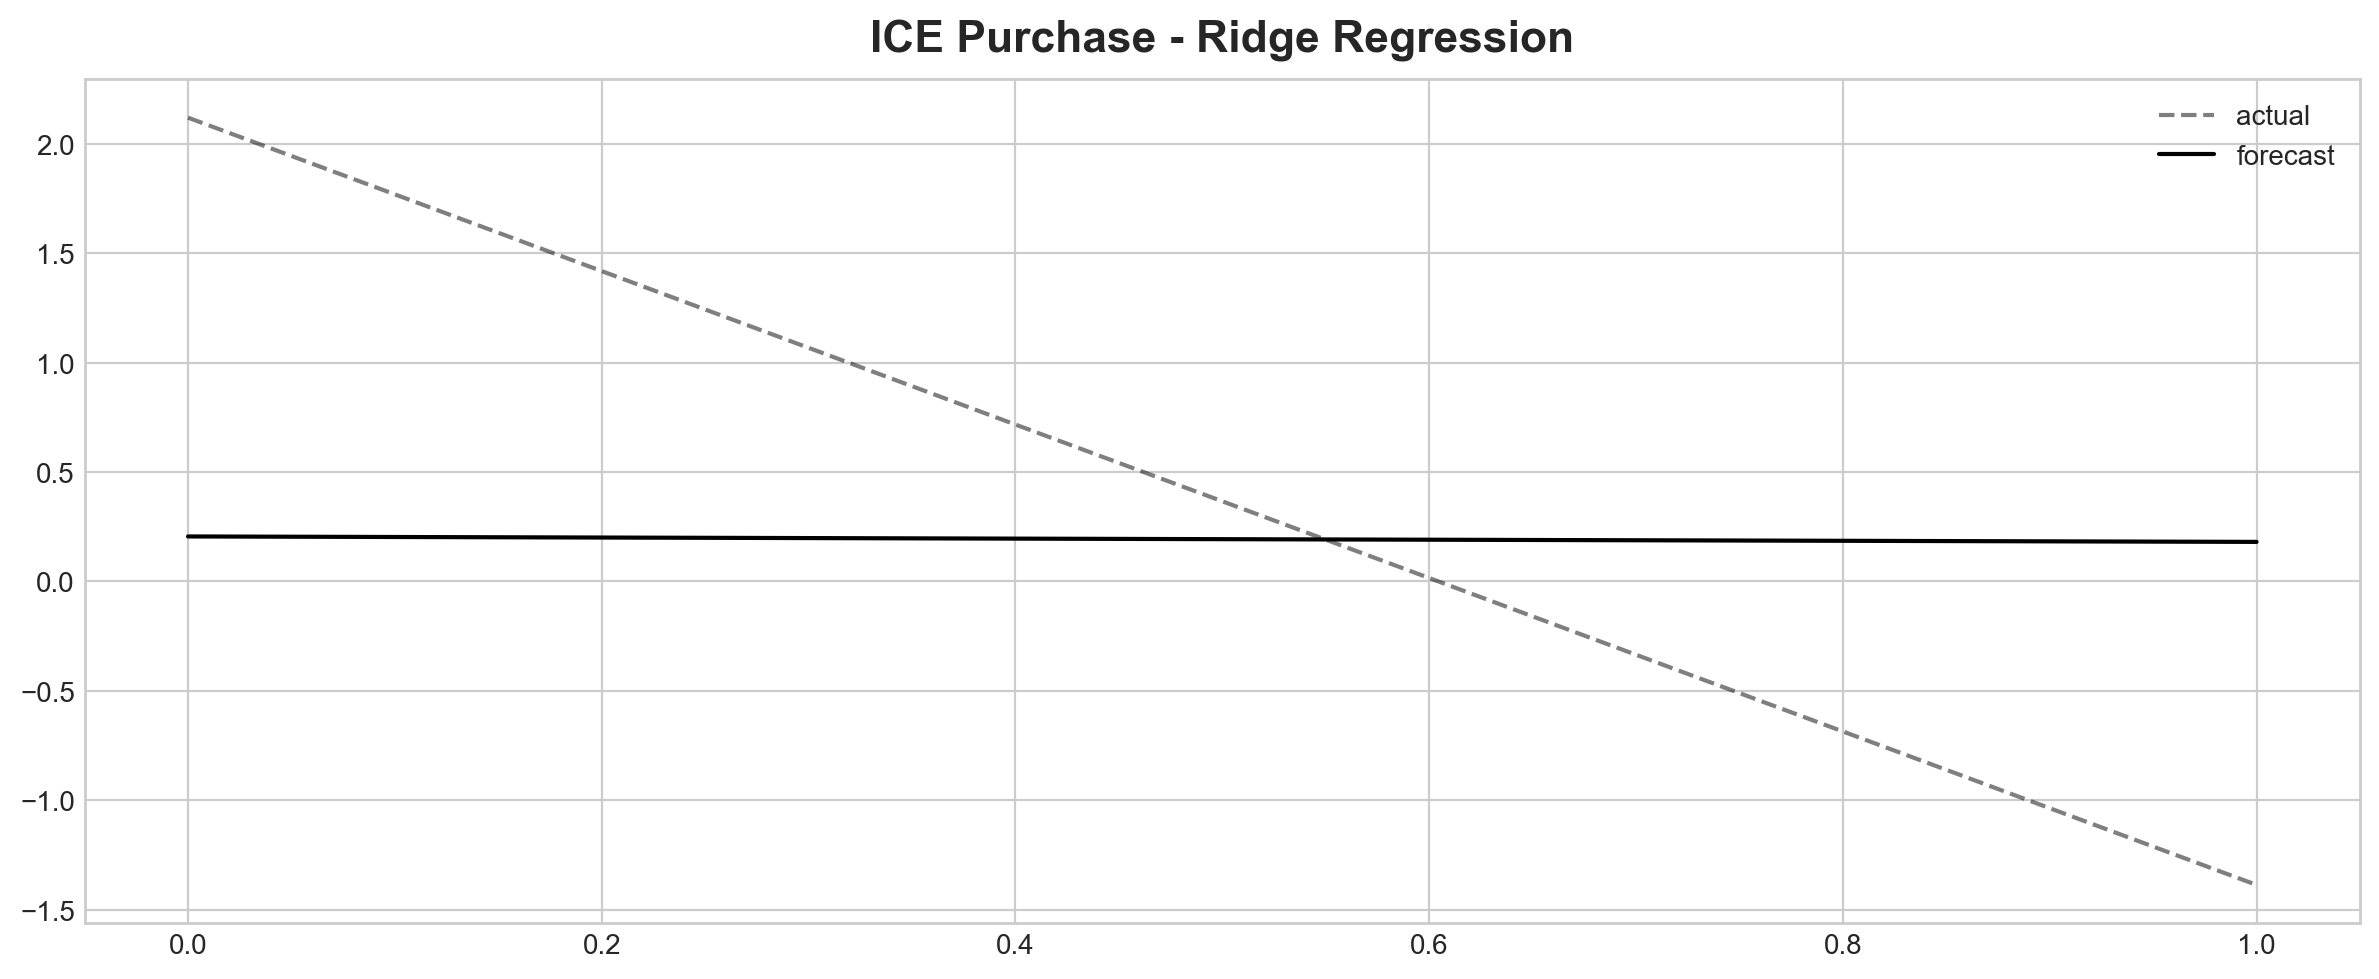

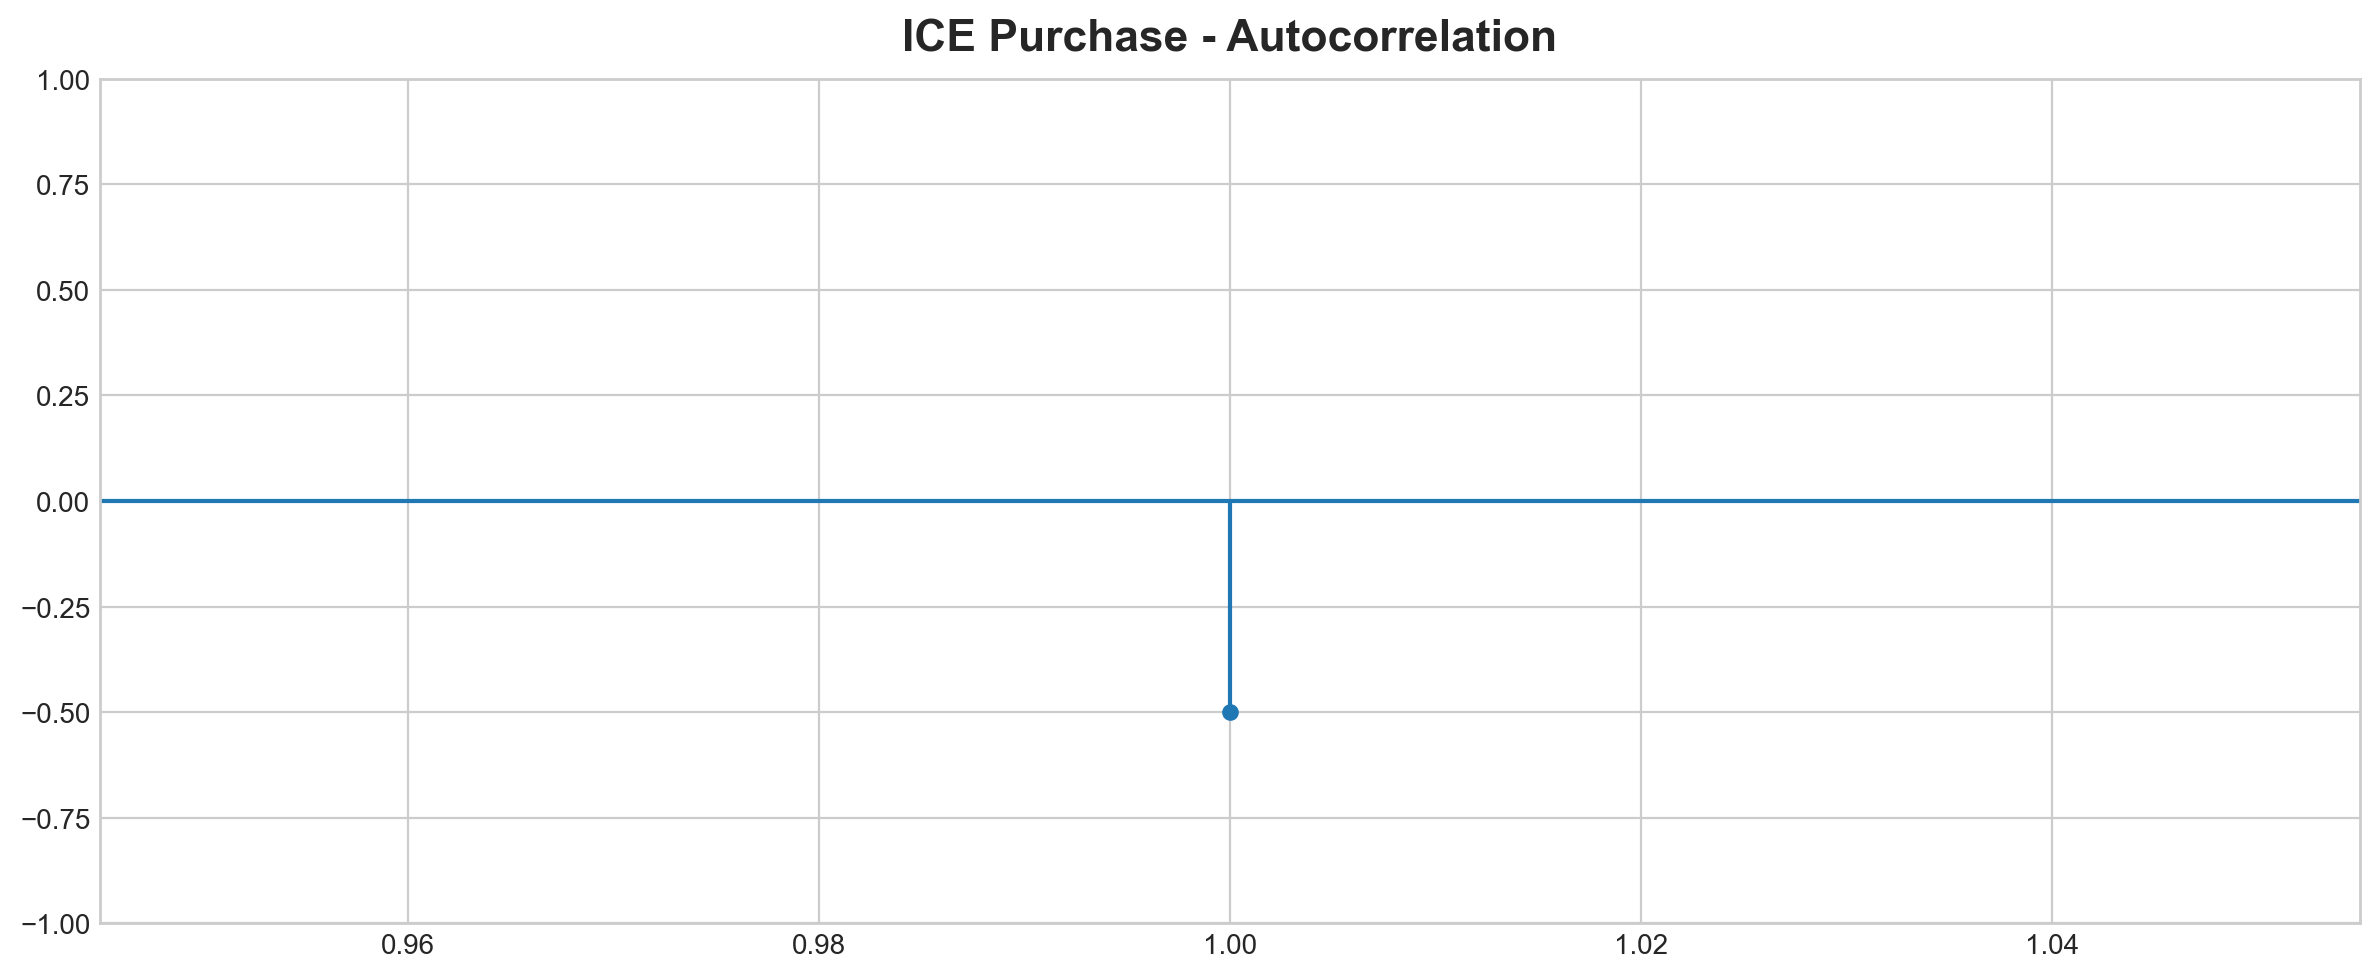

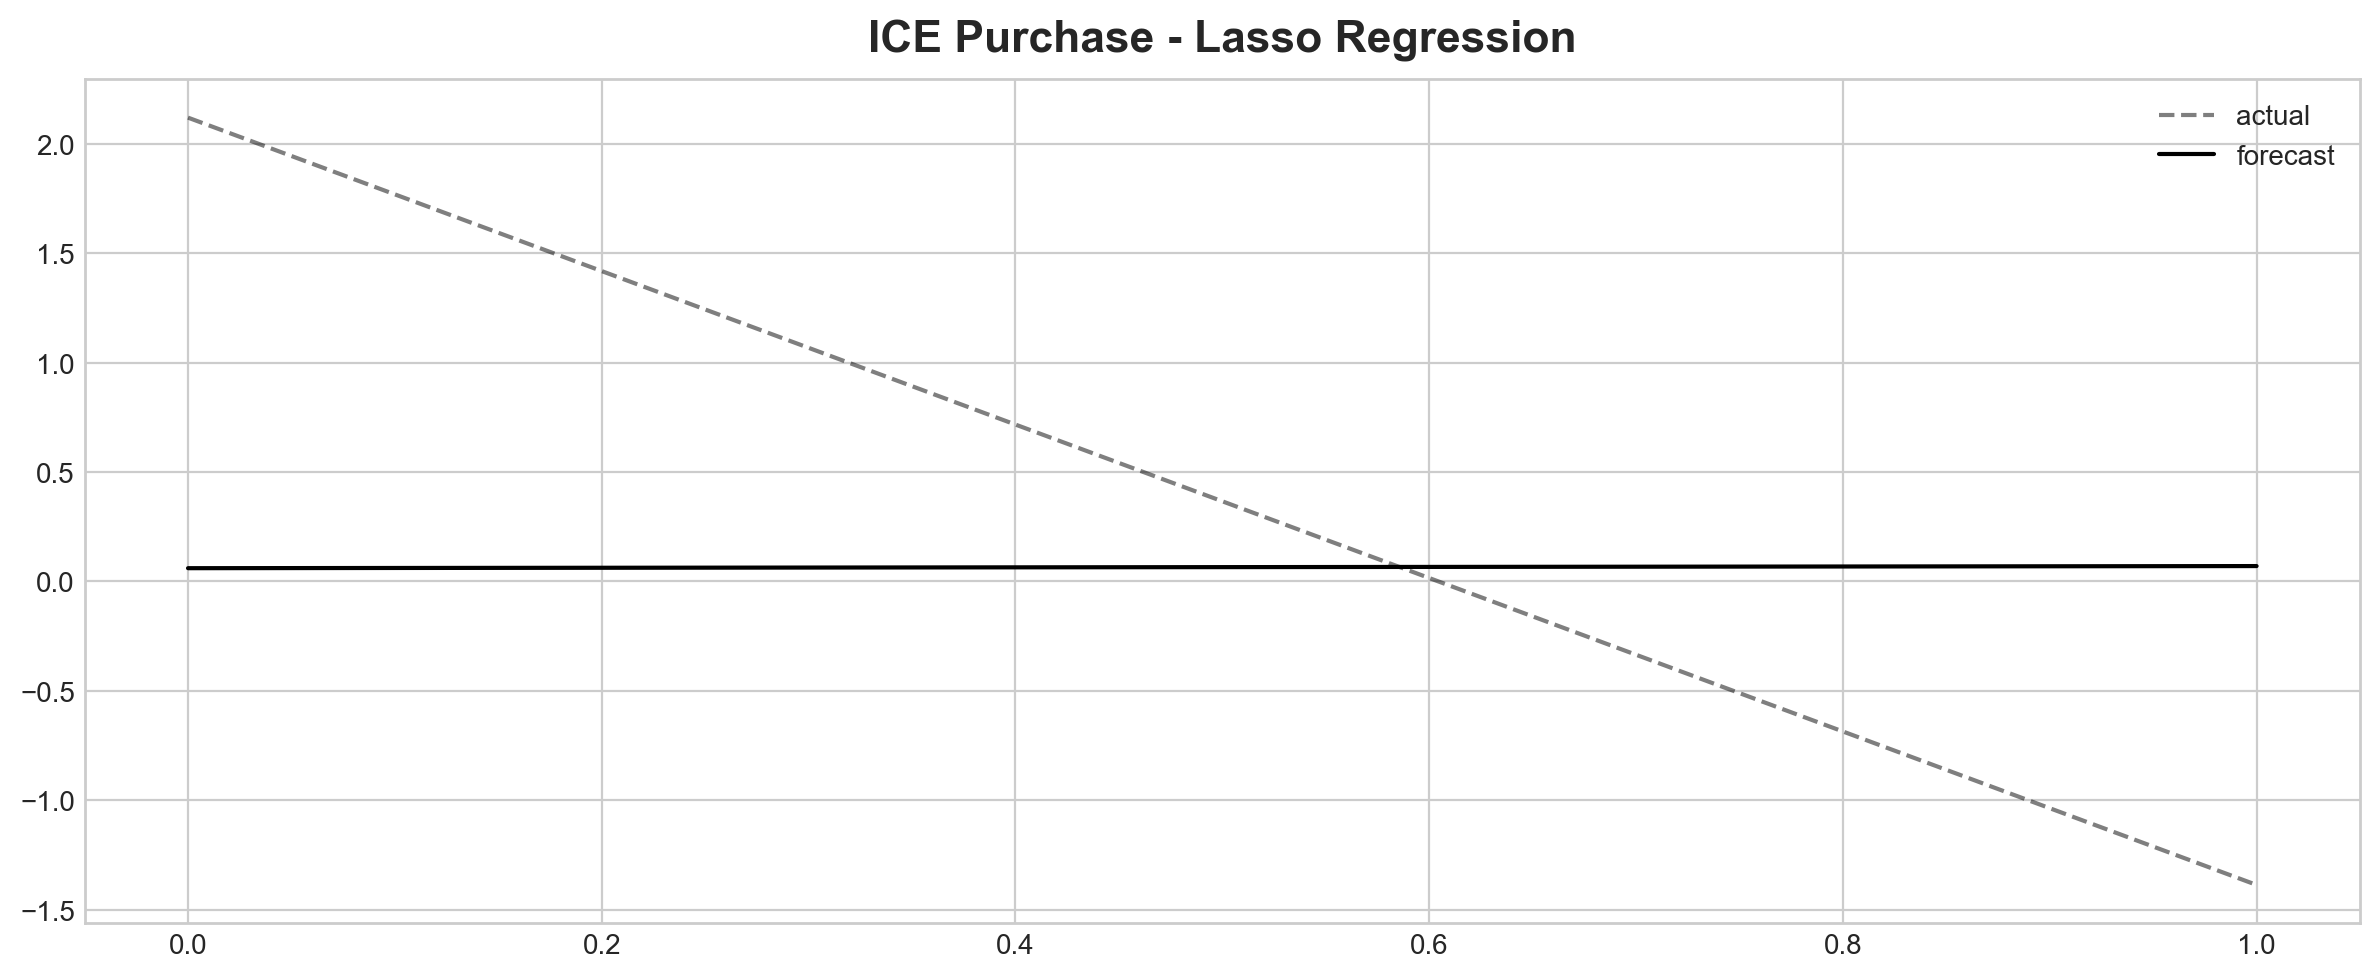

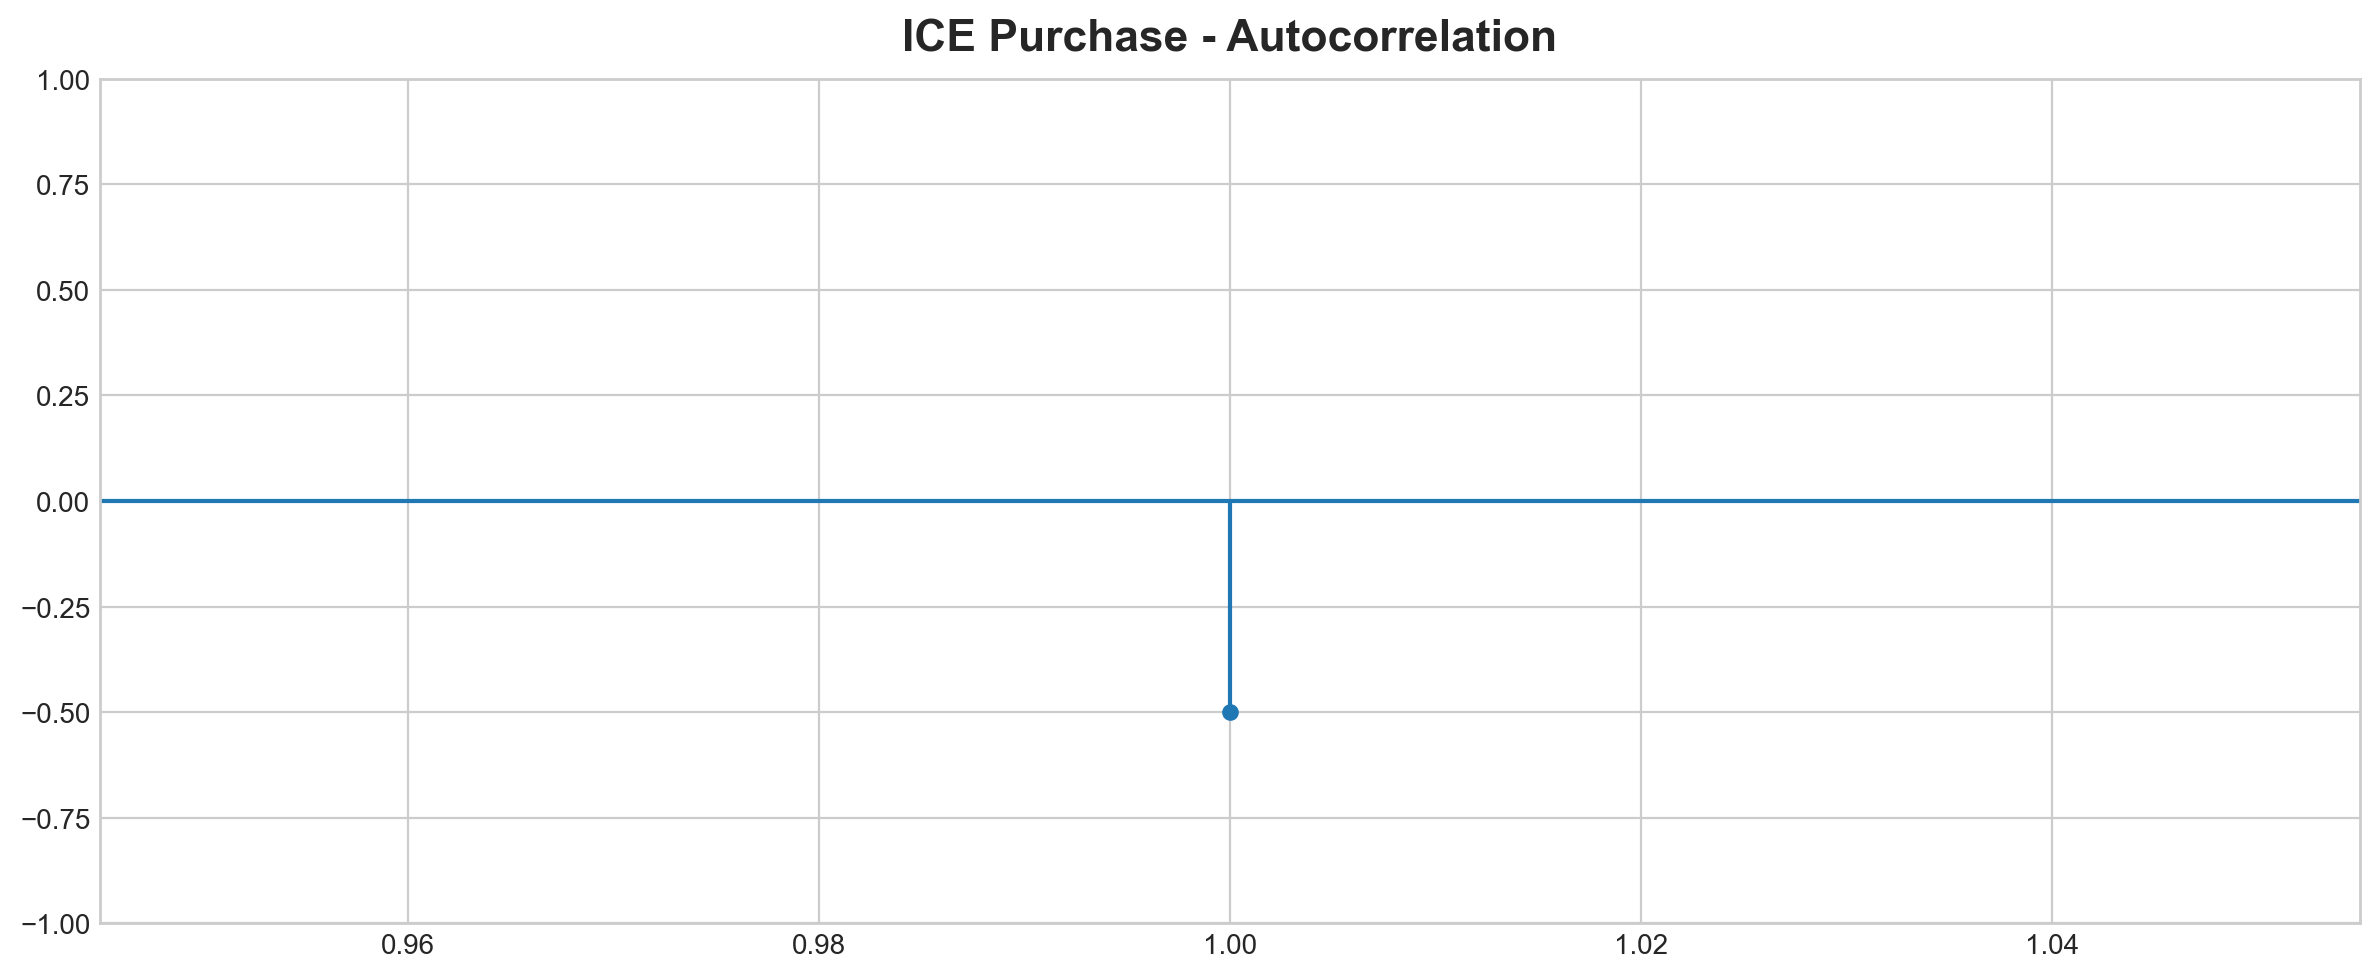

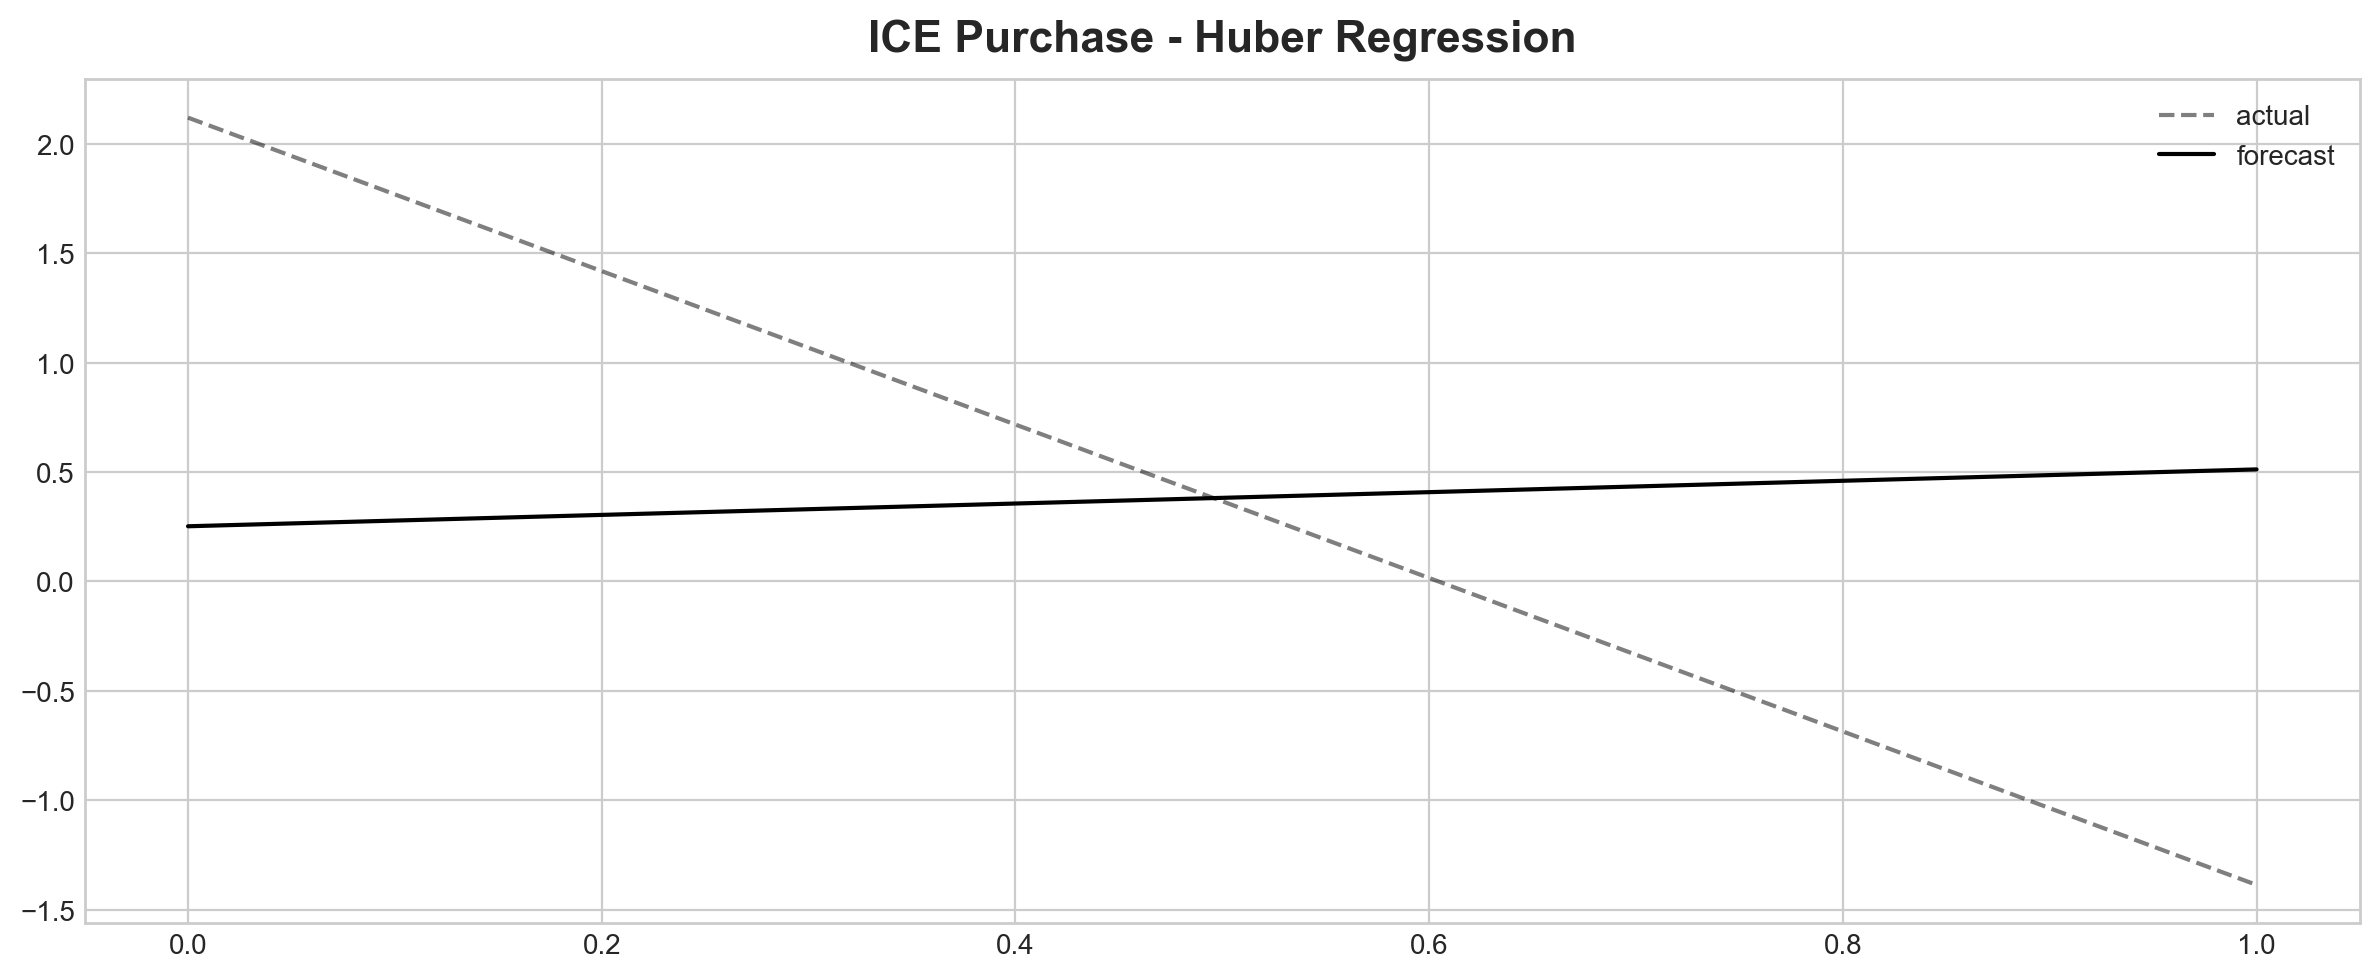

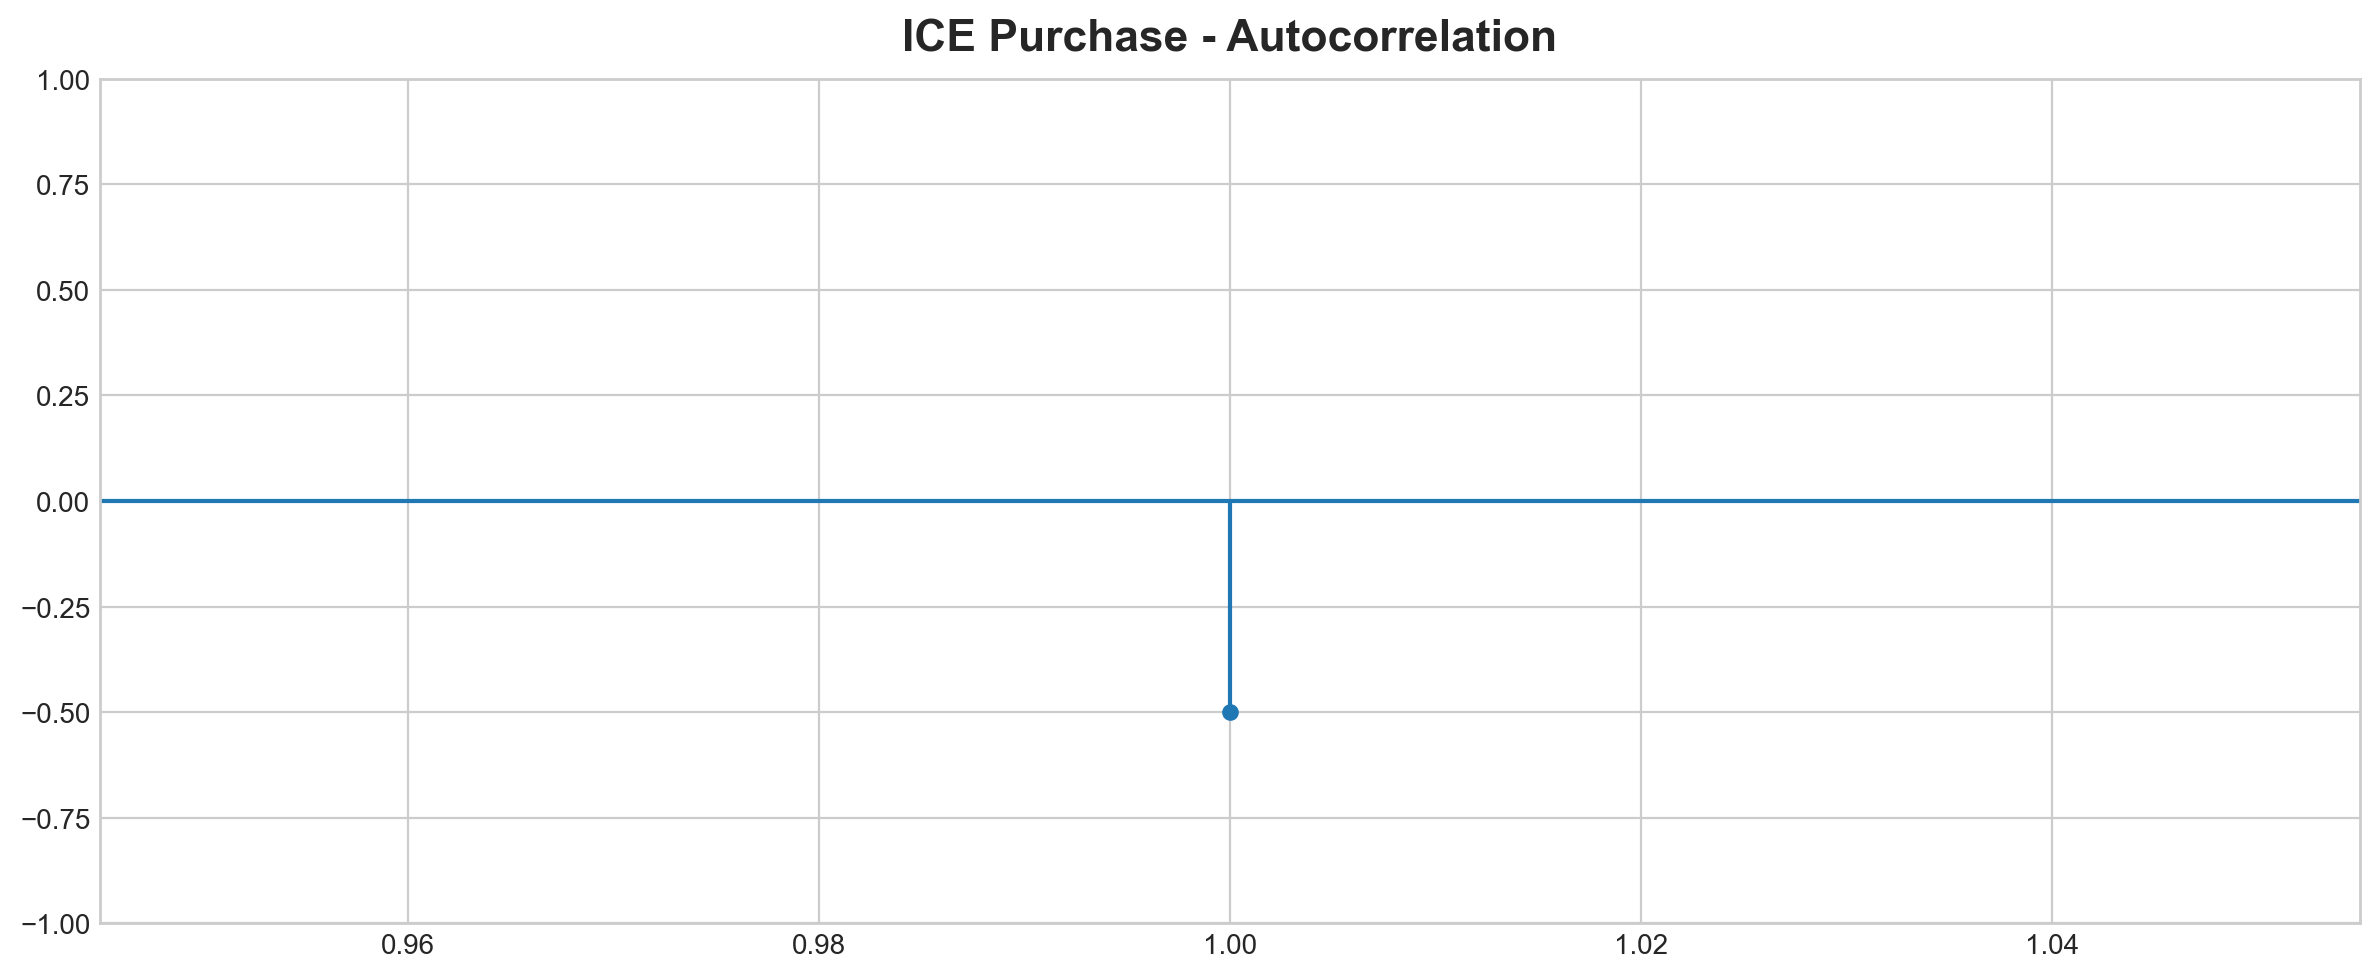

In [69]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, ice_results, 'ICE Purchase')

In [70]:
cols = ['Model Name', 'Model']
en_models = ice_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)

Linear Regression
[ 0.7312432  -0.28651772 -0.03258213]
Elastic Net
[ 0.3646126  -0.00227105 -0.        ]
Ridge Regression
[ 0.63963216 -0.28471321 -0.07890877]
Lasso Regression
[ 0.17418178 -0.         -0.        ]


NAIVE FORECASTER

In [18]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last", sp=1)

In [19]:
forecaster.fit(ice["count"])

NaiveForecaster()

In [20]:
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

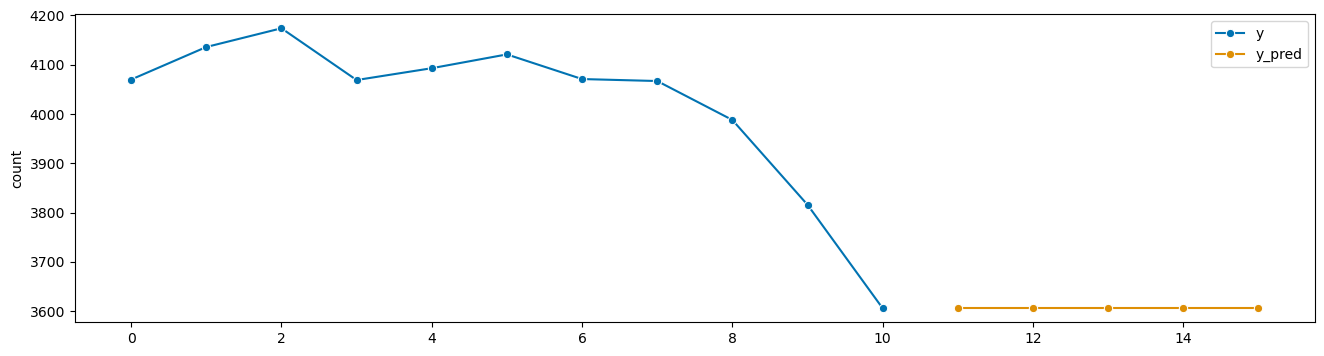

In [21]:
# plotting predictions and past data
plot_series(ice["count"], y_pred, labels=["y", "y_pred"])

In [25]:
from sktime.forecasting.arima import ARIMA
forecaster1 = ARIMA(order = (1,1,1),suppress_warnings=True)

In [26]:
forecaster1.fit(ice["count"])

ARIMA(order=(1, 1, 1), suppress_warnings=True)

In [27]:
y_pred = forecaster.predict(fh=fh)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='count'>)

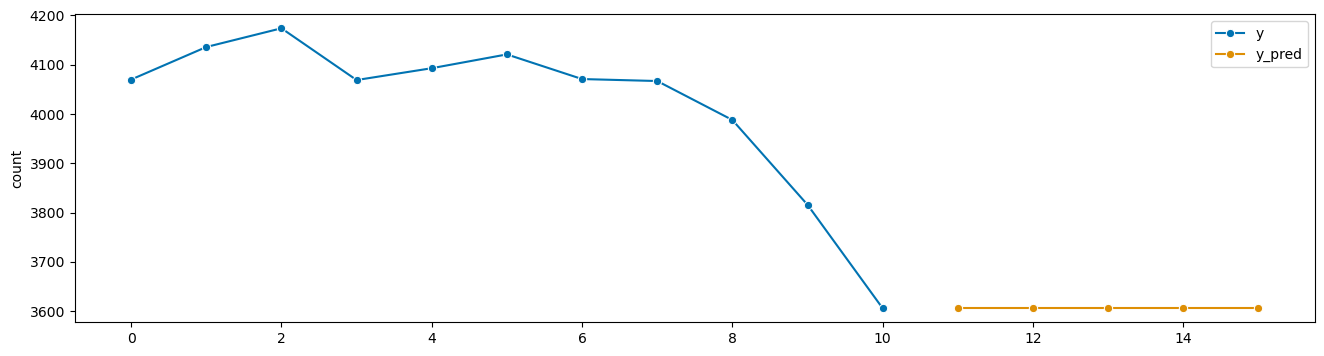

In [28]:
# plotting predictions and past data
plot_series(ice["count"], y_pred, labels=["y", "y_pred"])

ARIMA

In [75]:
ice

,y
year,
2011,4095
2012,4180
2013,4238
2014,4149
2015,4179
2016,4235
2017,4198
2018,4201
2019,4191


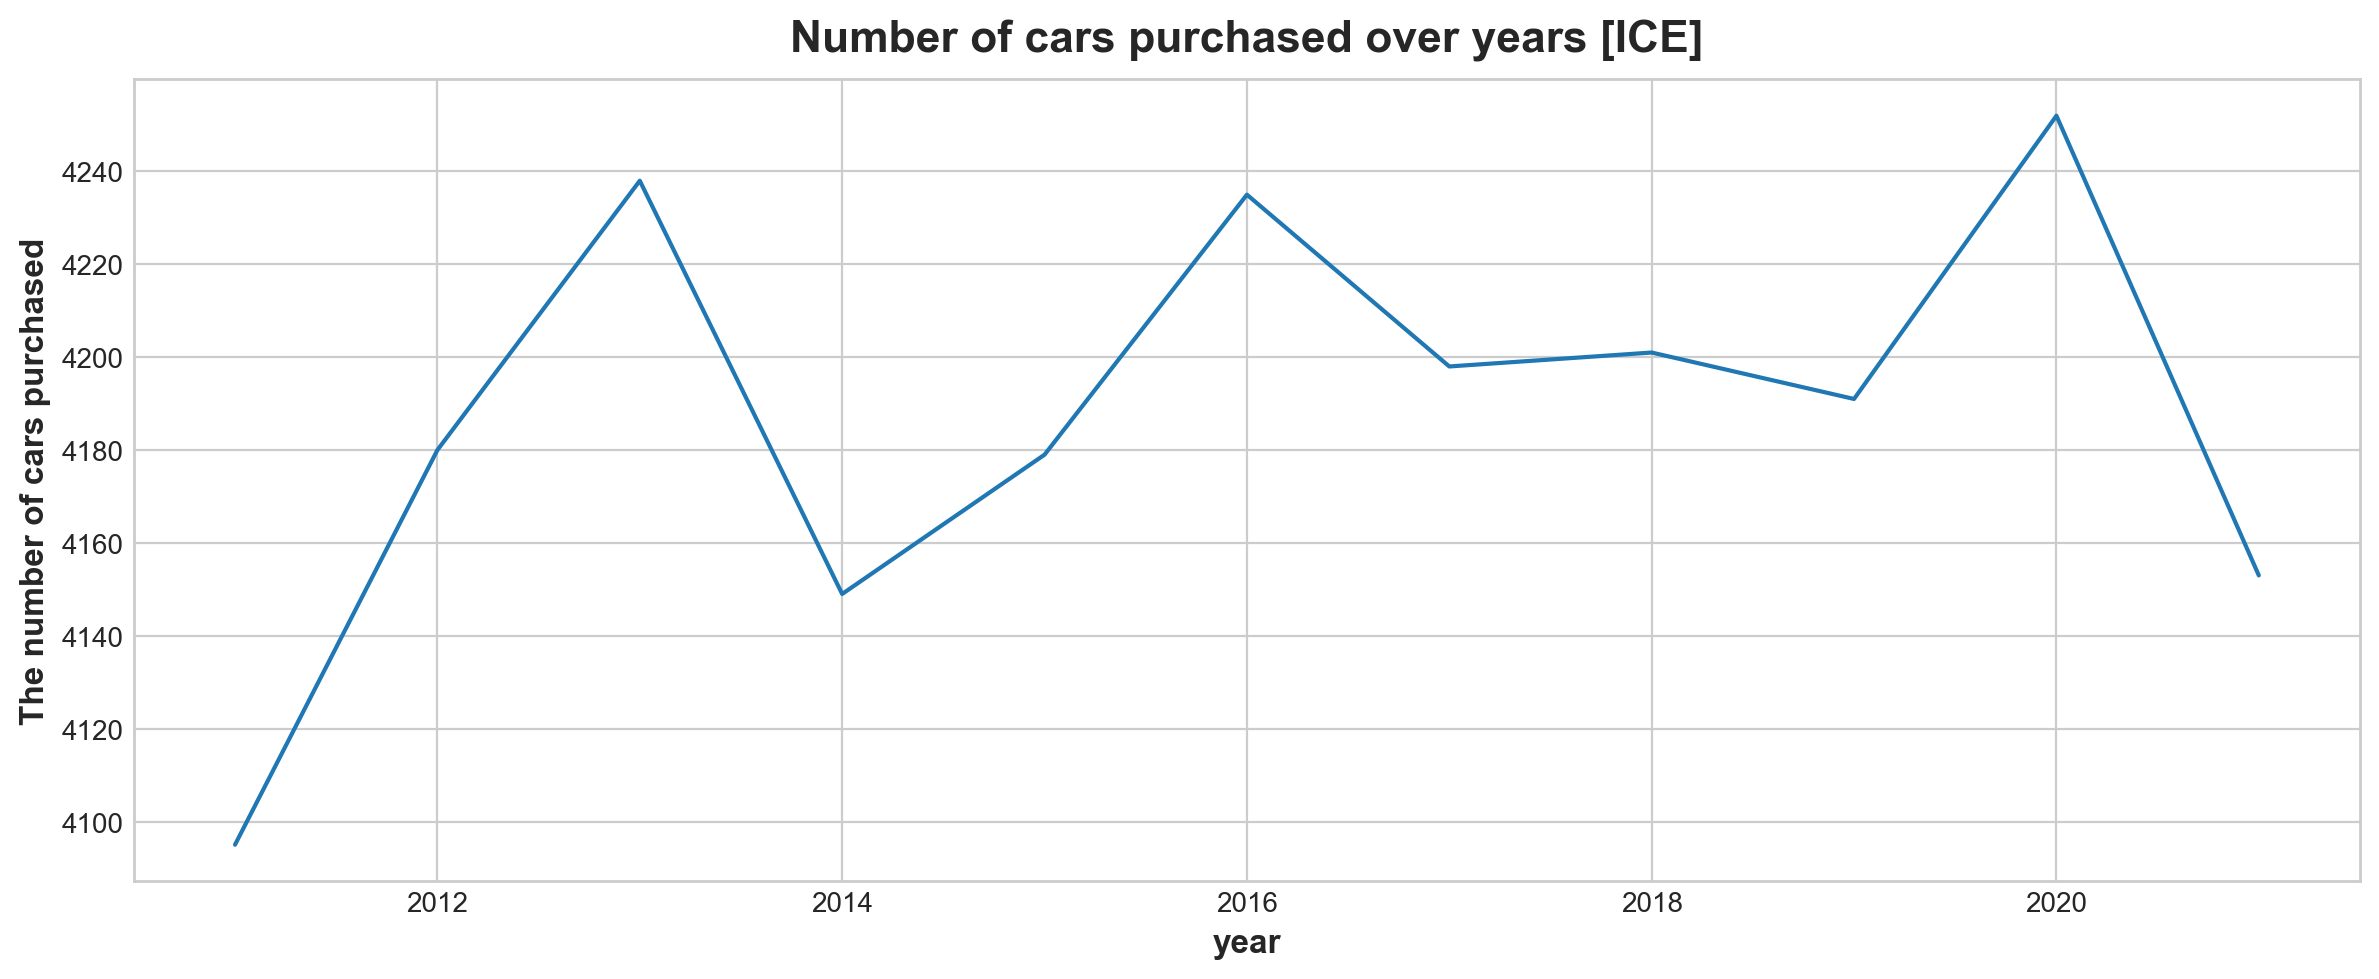

In [77]:
plt.title('Number of cars purchased over years [ICE]')
plt.xlabel('year')
plt.ylabel('The number of cars purchased')
sns.lineplot(data=ice,x='year', y='y')
plt.show()

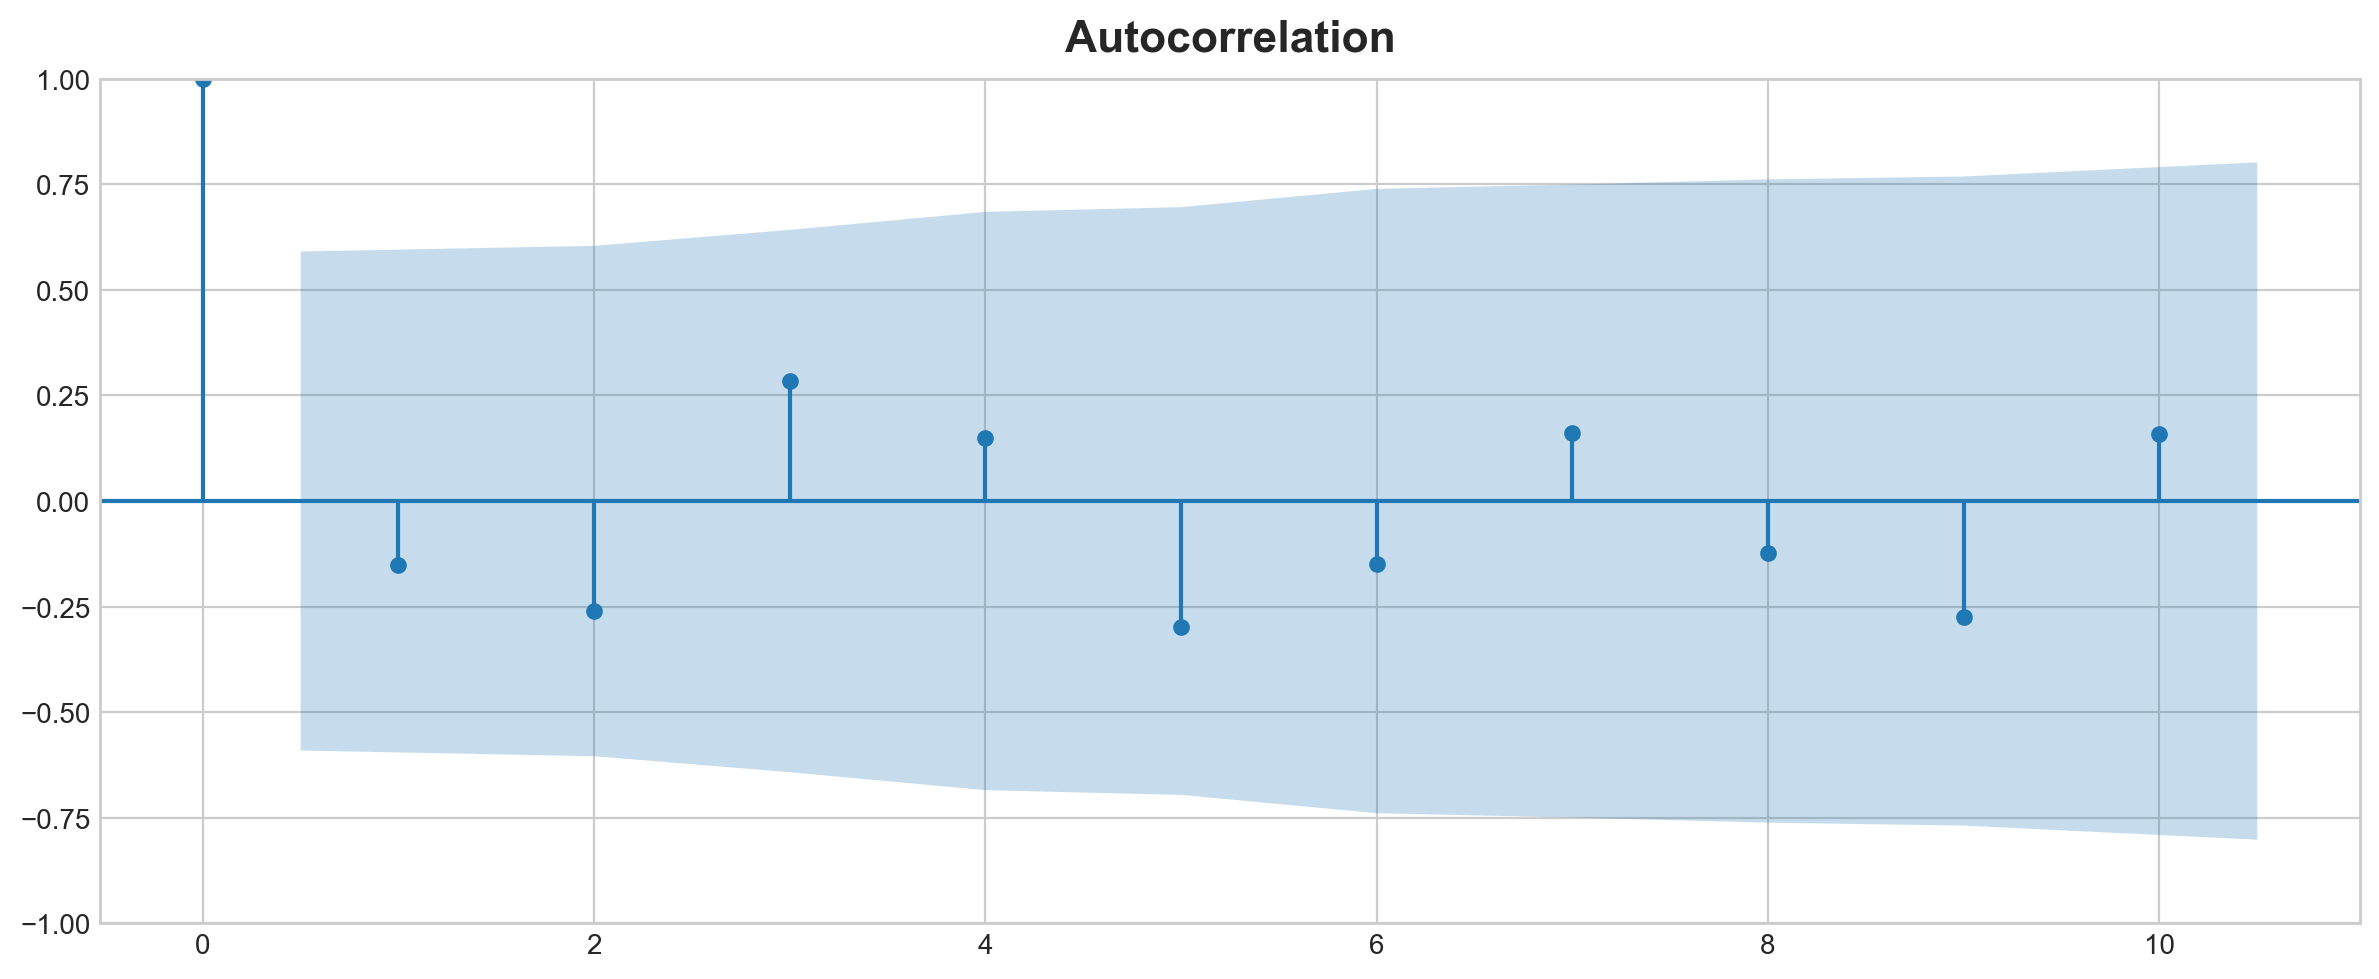

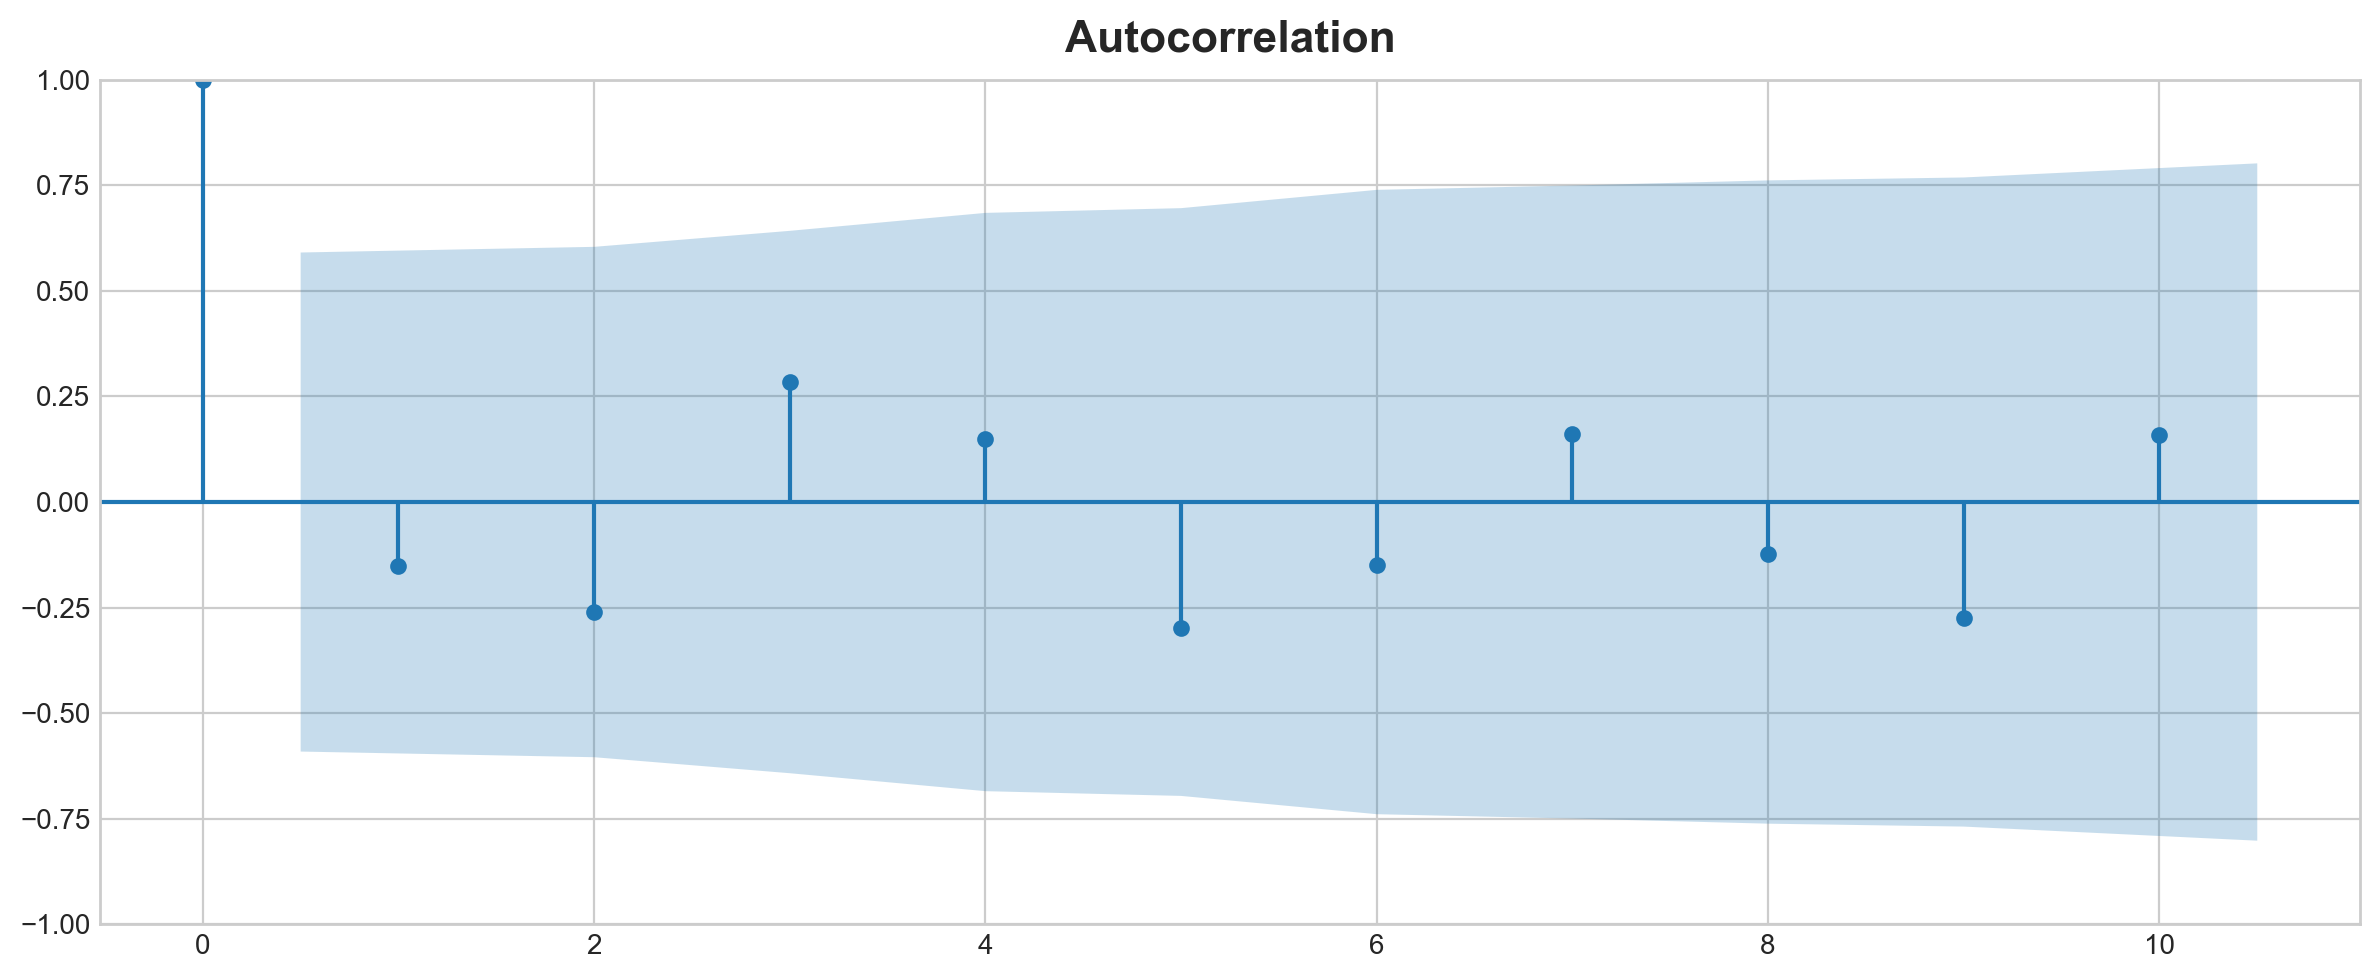

In [78]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ice["y"])

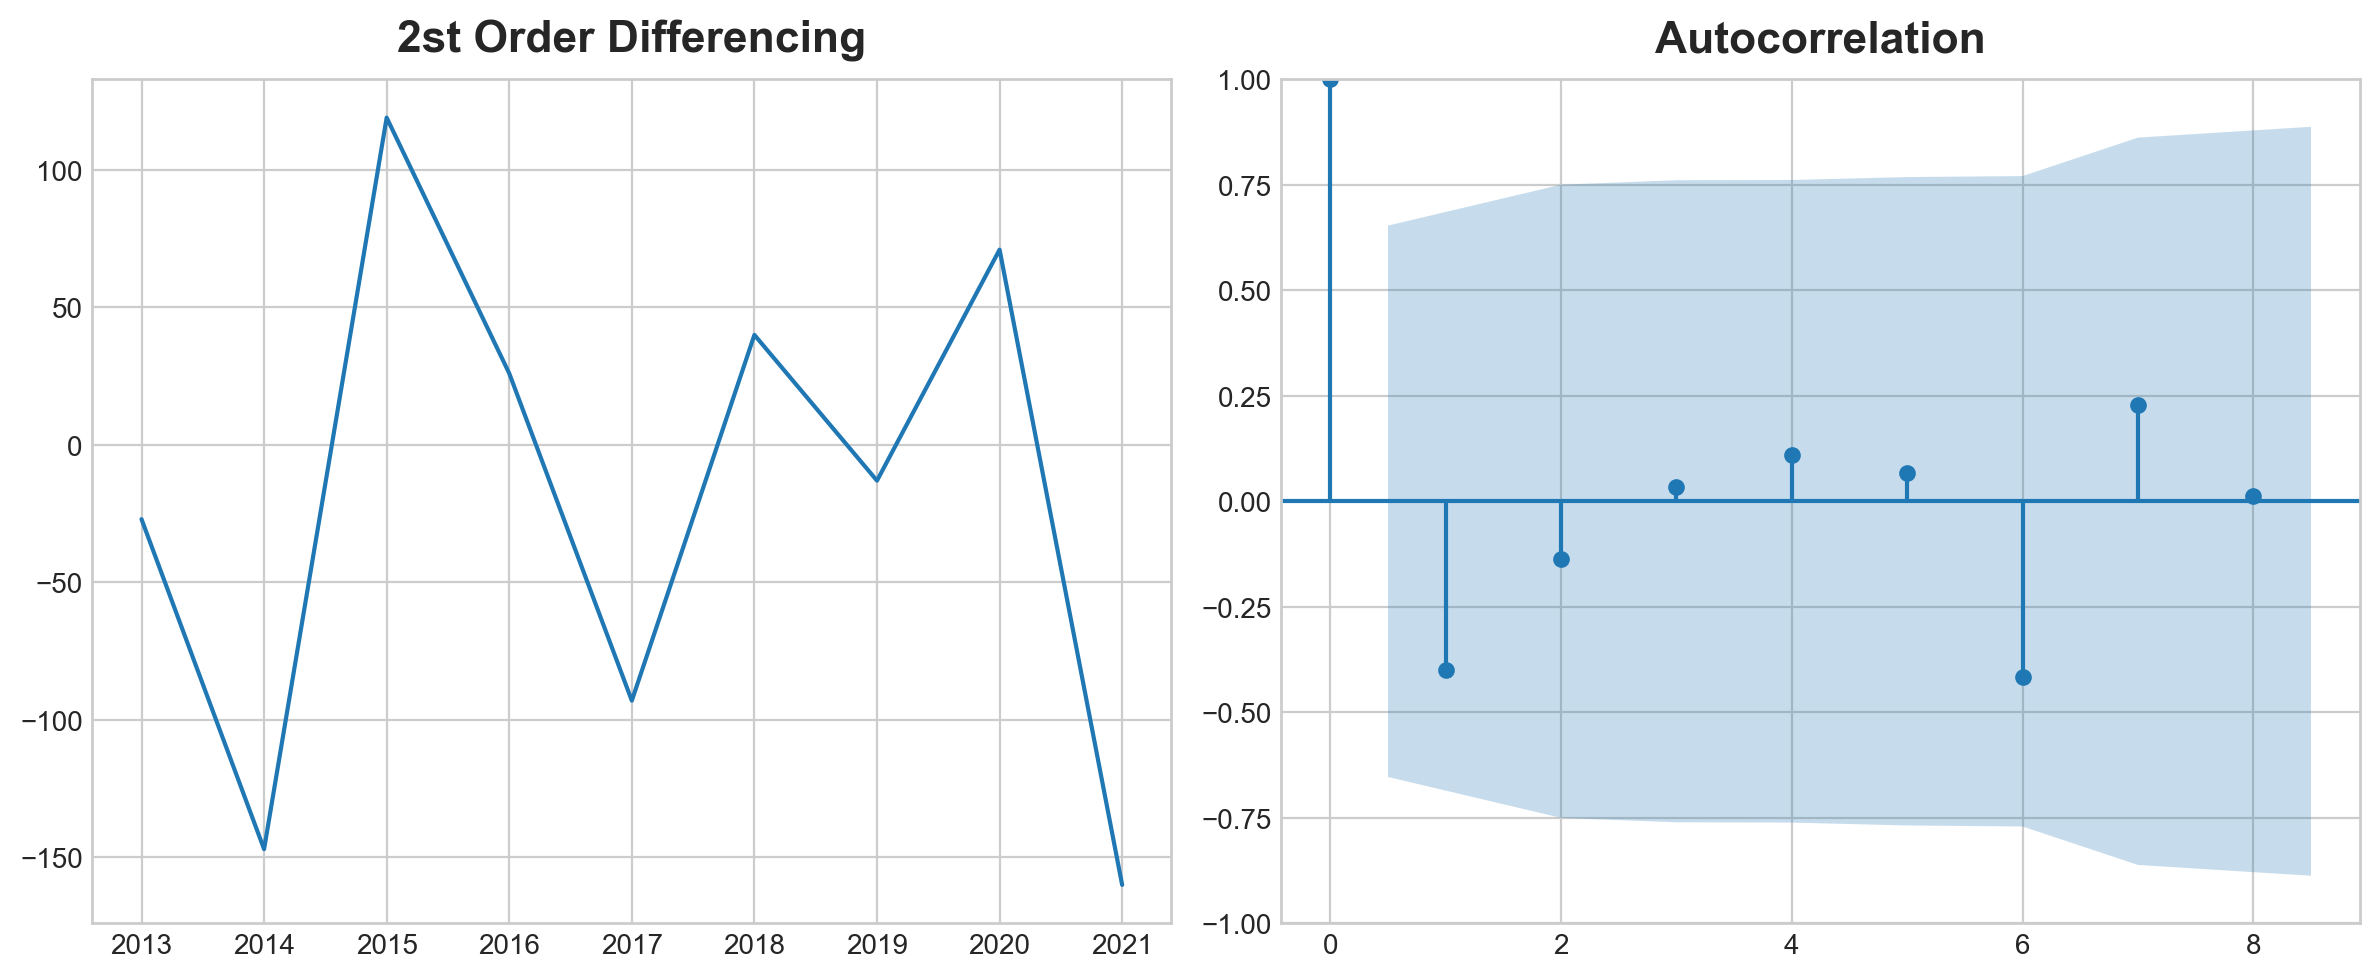

In [79]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2st Order Differencing")
ax1.plot(ice["y"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(ice["y"].diff().diff().dropna(), ax = ax2)
plt.show()


In [80]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [81]:
check_stationarity(ice["y"])

ADF Statistic: -1.393799
p-value: 0.585245
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Non-stationary


In [83]:
# 2nd Ordering
check_stationarity(ice["y"].diff().diff().dropna())

ADF Statistic: -6.065506
p-value: 0.000000
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Stationary


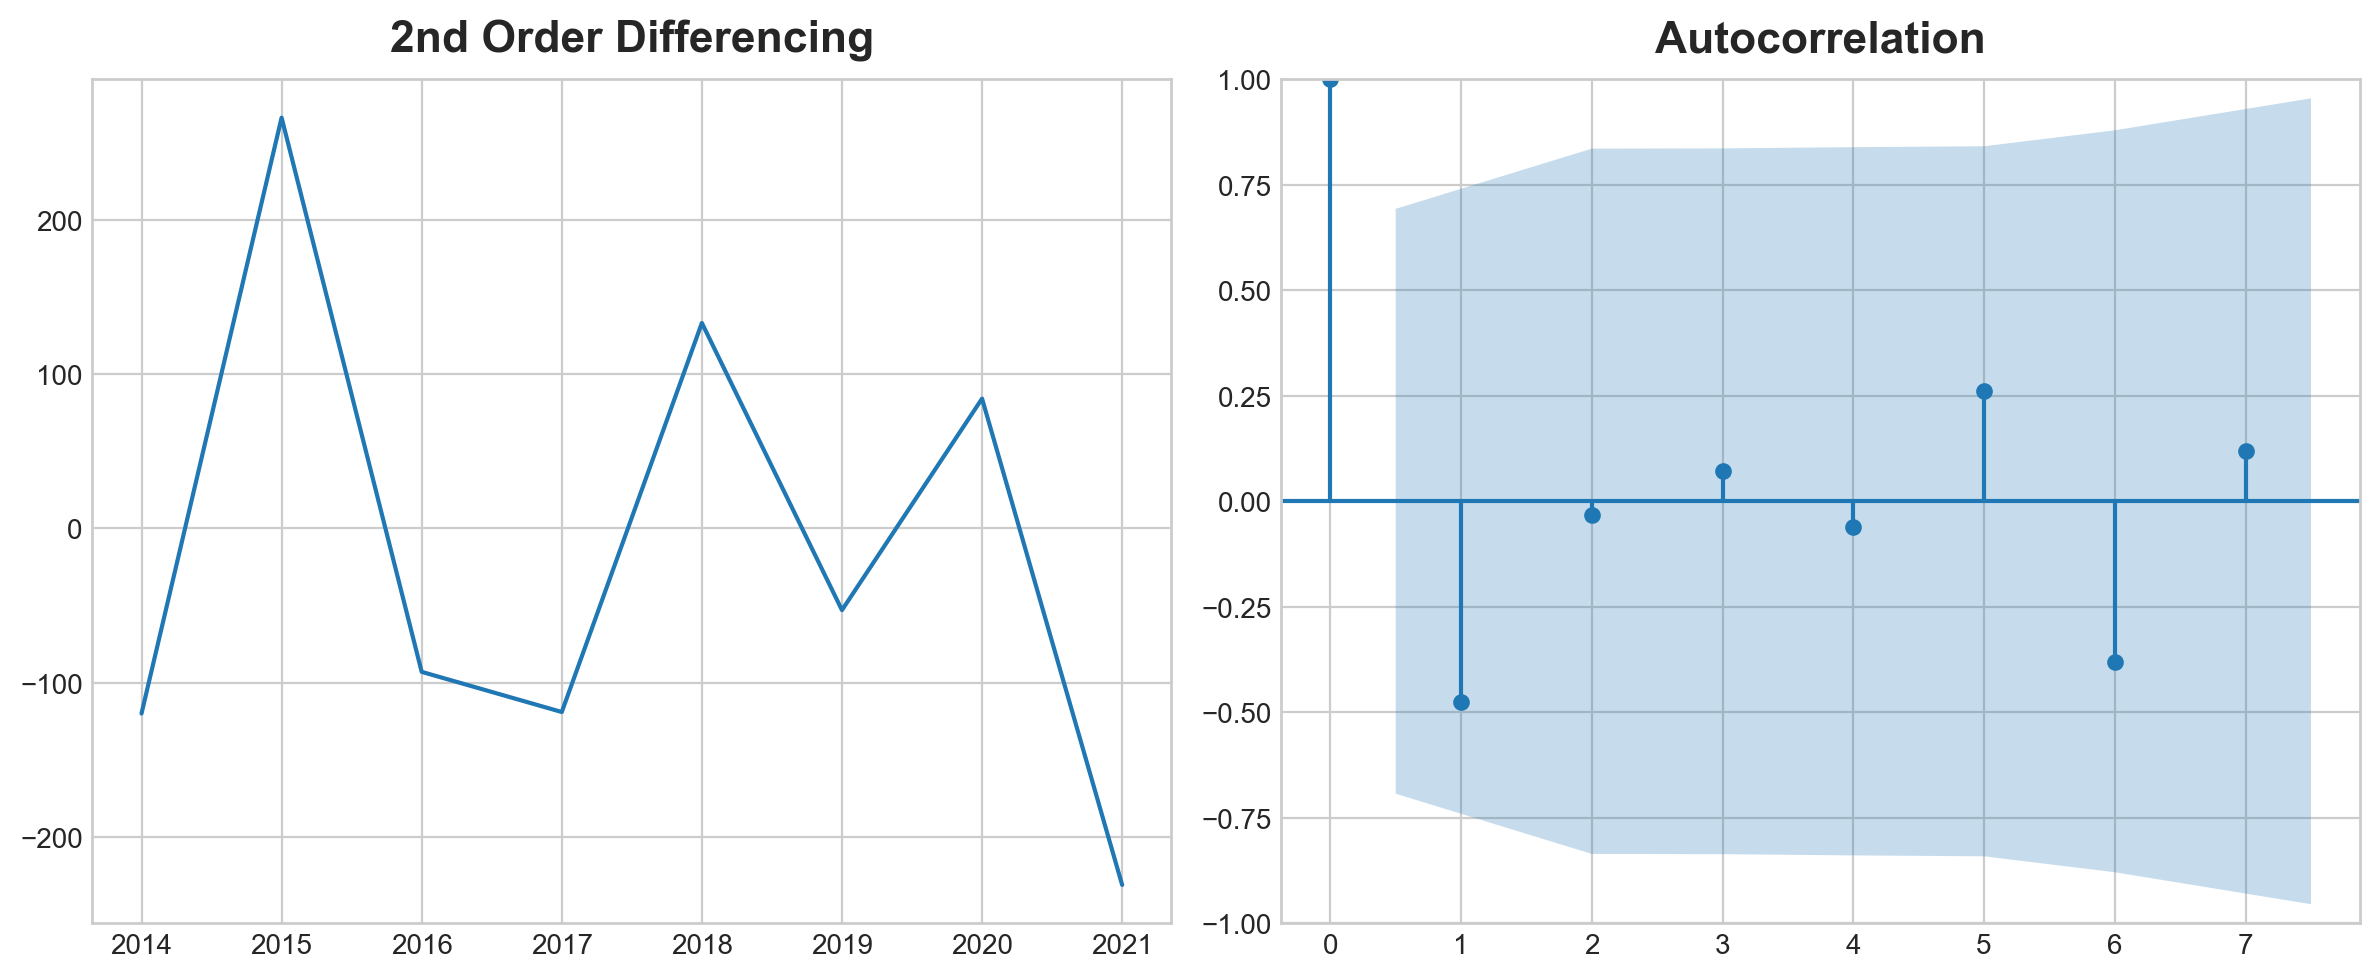

In [85]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(ice["y"].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(ice["y"].diff().diff().diff().dropna(), ax = ax2)
plt.show()


In [86]:
from statsmodels.tsa.arima.model import ARIMA

In [96]:
data = pd.read_csv(r"C:\Users\harri\Desktop\DataScienceProj\005_CarPurchase\EVnICE.csv")

In [97]:
data.head()

,Unnamed: 0,year,carType
0,0,2011,ICE
1,1,2011,ICE
2,2,2011,ICE
3,3,2011,ICE
4,4,2011,ICE


In [99]:
data.drop("Unnamed: 0", inplace=True, axis=1)

In [100]:
data

,year,carType
0,2011,ICE
1,2011,ICE
2,2011,ICE
3,2011,ICE
4,2011,ICE
...,...,...
46066,2021,ICE
46067,2021,ICE
46068,2021,ICE
46069,2021,ICE


In [101]:
data.groupby(["year"], as_index=False).count()

,year,carType
0,2011,4095
1,2012,4180
2,2013,4238
3,2014,4149
4,2015,4179
5,2016,4235
6,2017,4198
7,2018,4201
8,2019,4191
9,2020,4252


In [104]:
ice = ice = data.query('carType == "ICE"').groupby(["year"], as_index=False).count()
ice.rename(columns={"carType": "count"}, inplace=True)
ice

,year,count
0,2011,4092
1,2012,4170
2,2013,4217
3,2014,4098
4,2015,4126
5,2016,4164
6,2017,4139
7,2018,4149
8,2019,4093
9,2020,4142


In [105]:
df_test = ice[[ 'year','count']].loc[9:]
df = ice[[ 'year','count']].loc[:8]
df_test

,year,count
9,2020,4142
10,2021,4020


In [109]:
arima_model = ARIMA(df["count"], order=(1,2,1))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                    9
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -40.399
Date:                Wed, 01 Feb 2023   AIC                             86.797
Time:                        10:55:19   BIC                             86.635
Sample:                             0   HQIC                            84.791
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0448      1.278     -0.035      0.972      -2.550       2.461
ma.L1         -0.9969    119.412     -0.008      0.993    -235.041     233.047
sigma2      3992.0783   4.75e+05      0.008      0.9

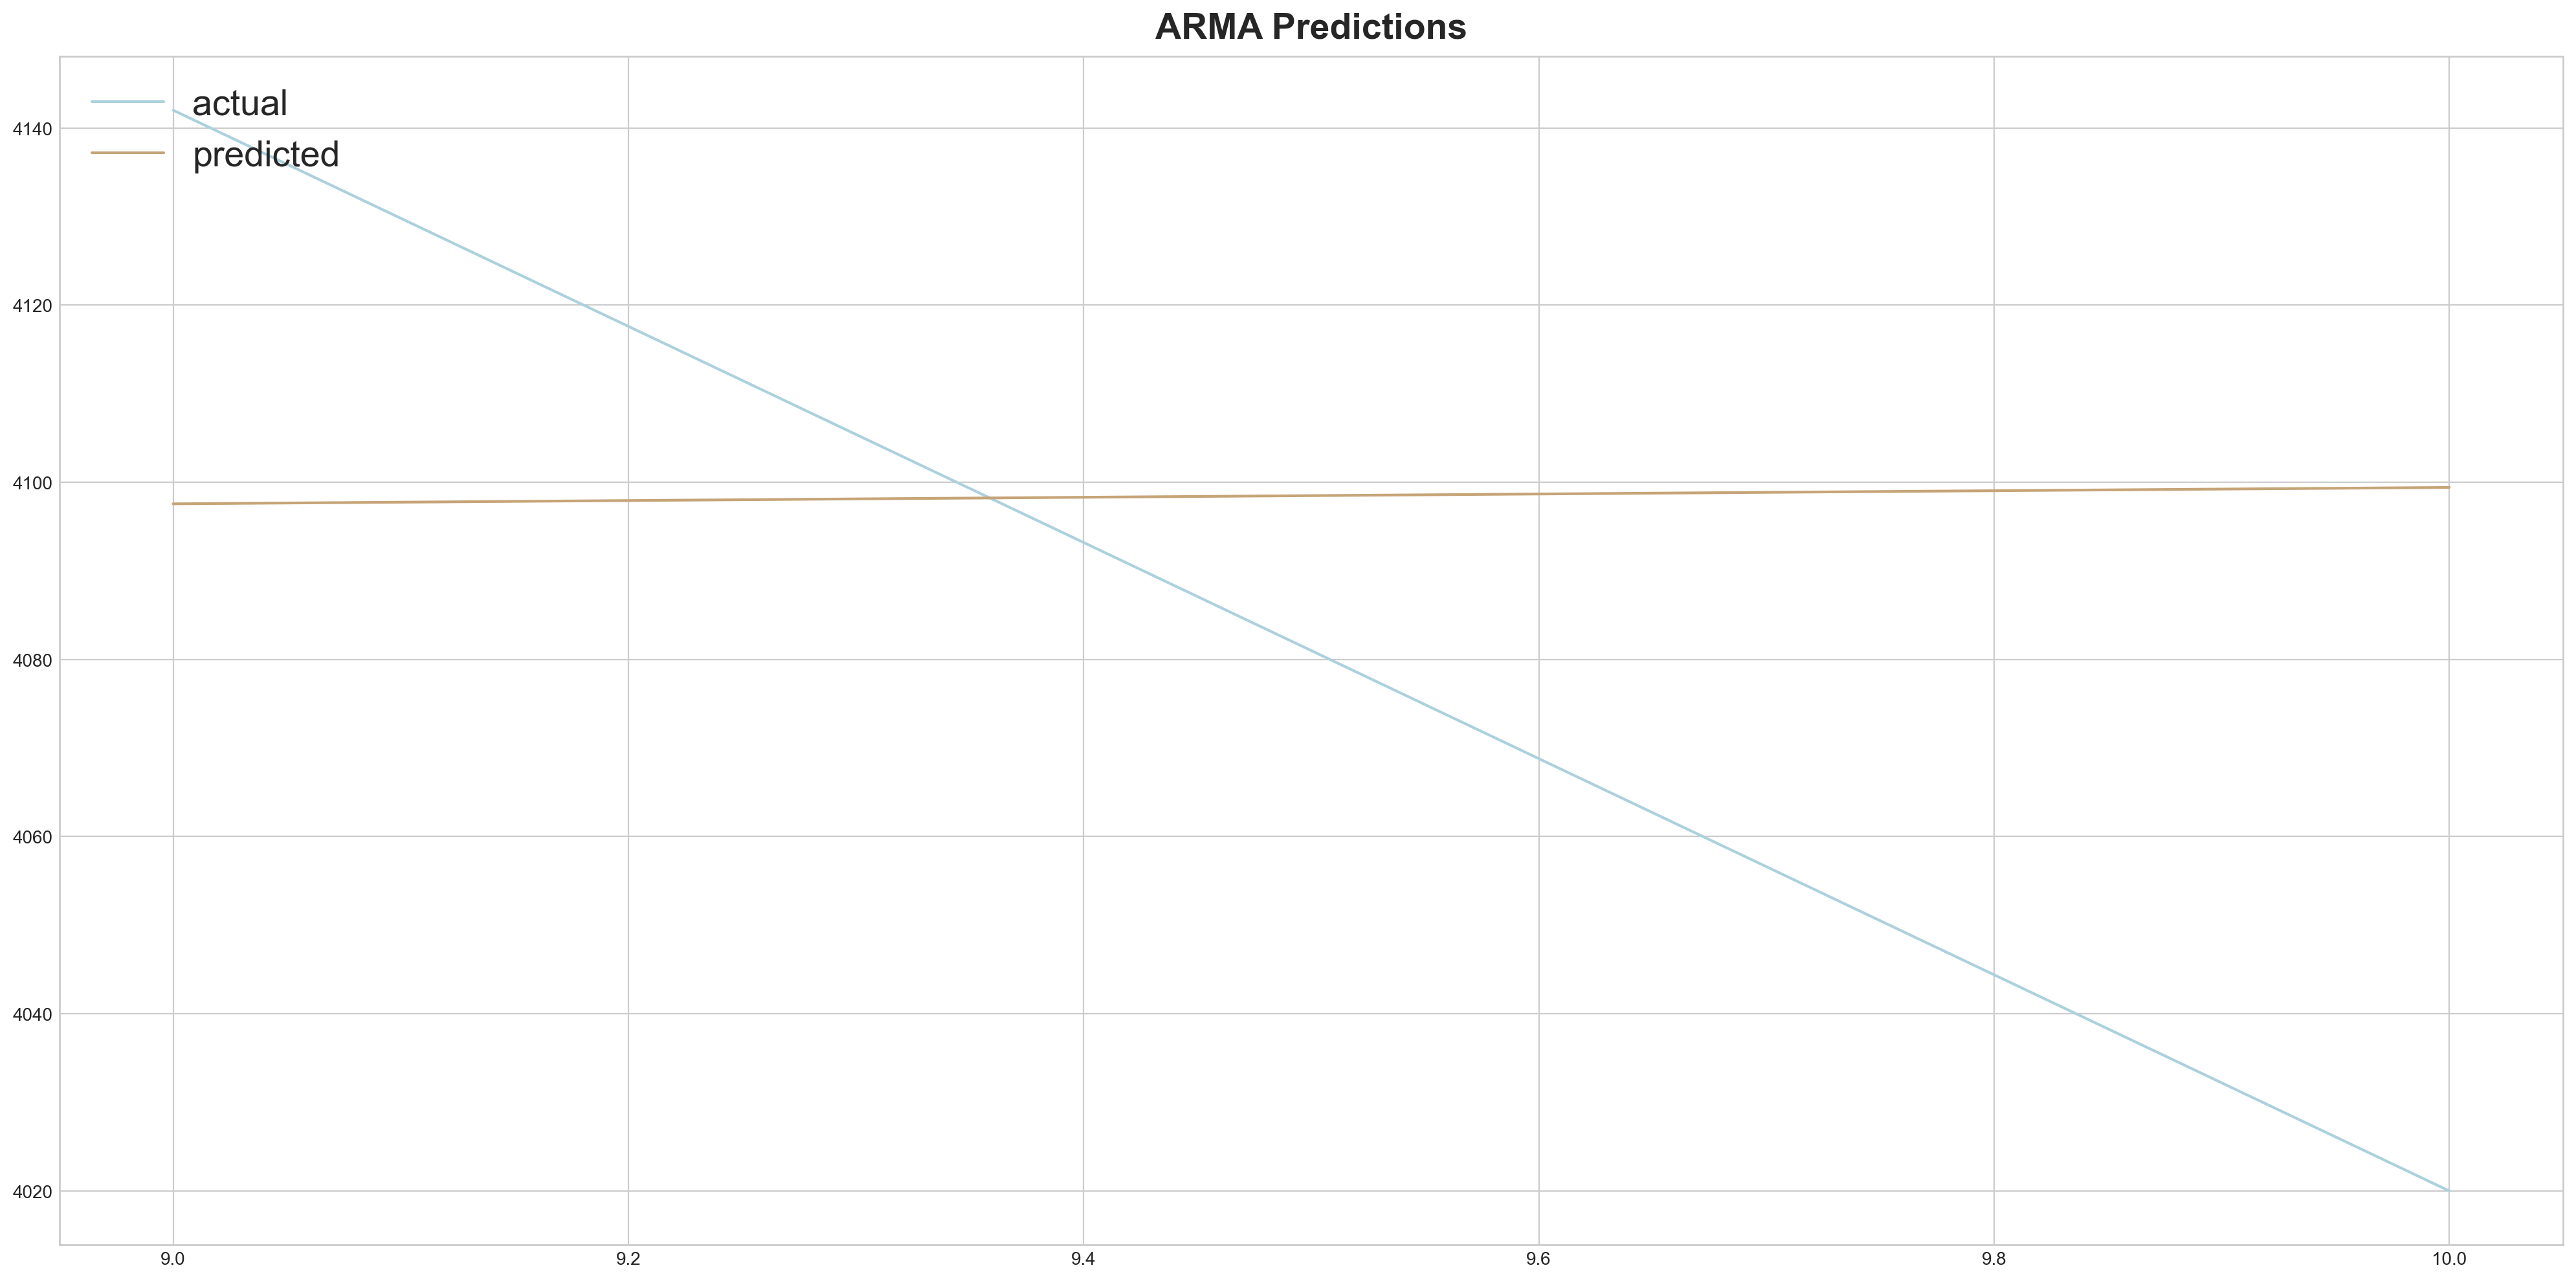

In [110]:
# generate predictions
df_pred = model.predict(start=9, end=10)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test['count'], label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [111]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                    9
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 -40.399
Date:                Wed, 01 Feb 2023   AIC                             86.797
Time:                        10:55:27   BIC                             86.635
Sample:                             0   HQIC                            84.791
                                  - 9                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0448      1.278     -0.035      0.972      -2.550       2.461
ma.L1         -0.9969    119.412     -0.008      0.993    -235.041     233.047
sigma2      3992.0783   4.75e+05      0.008      0.993   -9.27e+05    9.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 1.35
Prob(Q):                              0.54   Prob(JB):                         0.51
Heteroskedasticity (H):               0.15   Skew:                            -1.07
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Recursive multi-step forecasting

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [124]:
ice.rename(columns={"count": "y"}, inplace=True)
ice_cp = ice.copy()

In [128]:
ice_cp = ice_cp.set_index("year")
ice_cp

,y
year,
2011,4092
2012,4170
2013,4217
2014,4098
2015,4126
2016,4164
2017,4139
2018,4149
2019,4093


In [129]:
ice_cp = ice_cp['y']

In [132]:
steps = 2
data_train = ice_cp[:-steps]
data_test  = ice_cp[-steps:]

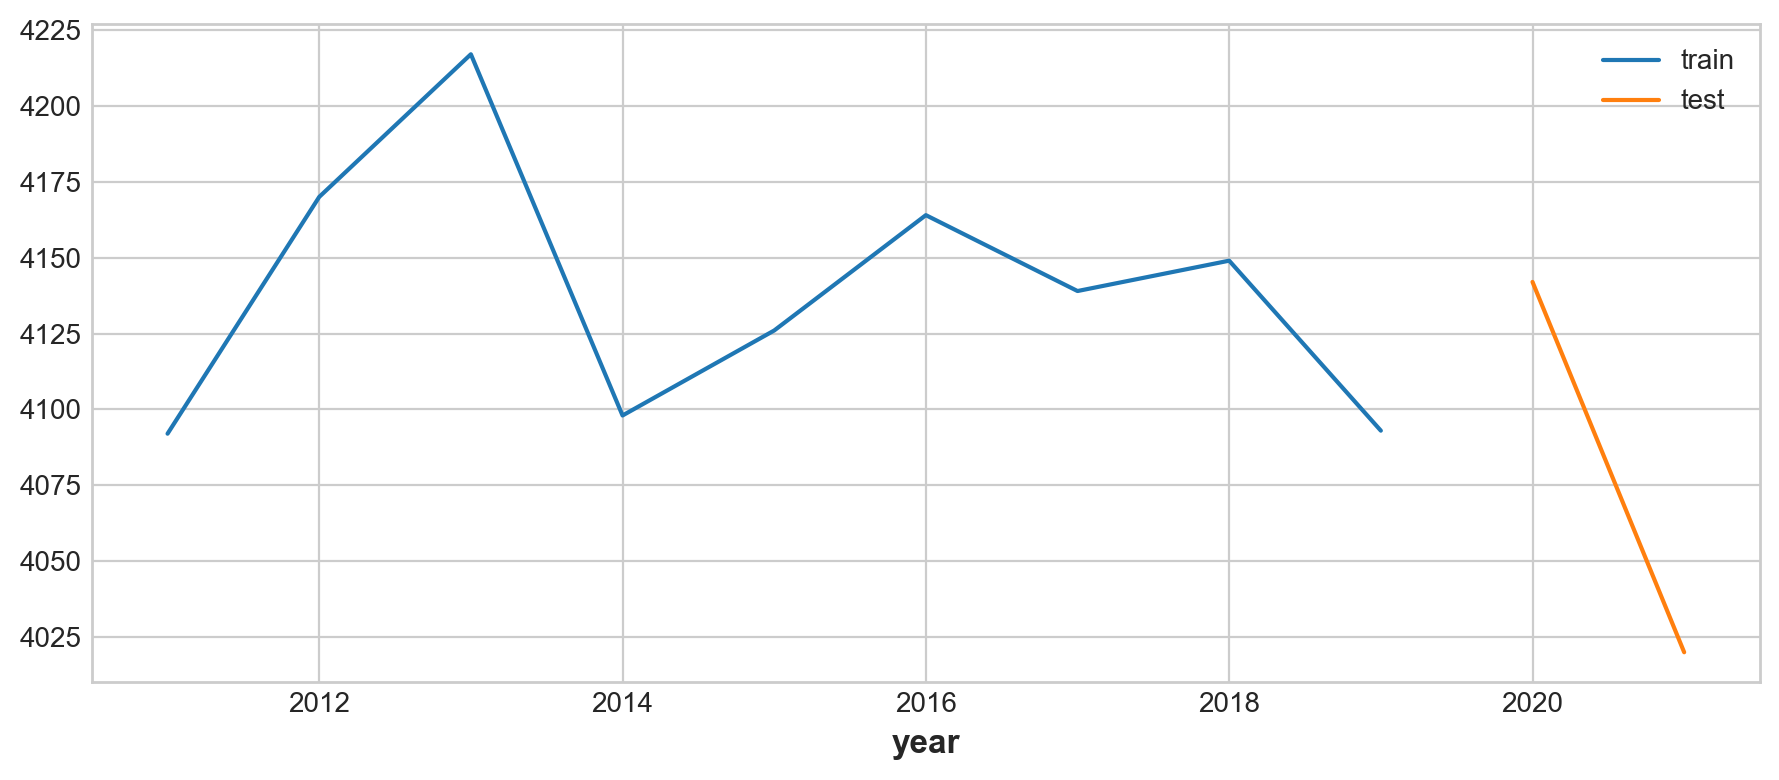

In [134]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

In [135]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 8
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 8] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-02-01 12:04:48 
Last fit date: 2023-02-01 12:04:48 
Skforecast version: 0.6.0 
Python version: 3.9.16 

In [136]:
predictions = forecaster.predict(steps=2)
predictions.head()

8    4093.0
9    4093.0
Name: pred, dtype: float64

In [142]:
predictions.index = [2020,2021]

In [143]:
data_train

year
2011    4092
2012    4170
2013    4217
2014    4098
2015    4126
2016    4164
2017    4139
2018    4149
2019    4093
Name: y, dtype: int64

In [146]:
ahead_predictions = forecaster.predict(steps=7)
ahead_predictions

8     4093.0
9     4093.0
10    4093.0
11    4093.0
12    4093.0
13    4093.0
14    4093.0
Name: pred, dtype: float64

In [148]:
ahead_predictions.index = [2020,2021,2022,2023,2024,2025,2026]

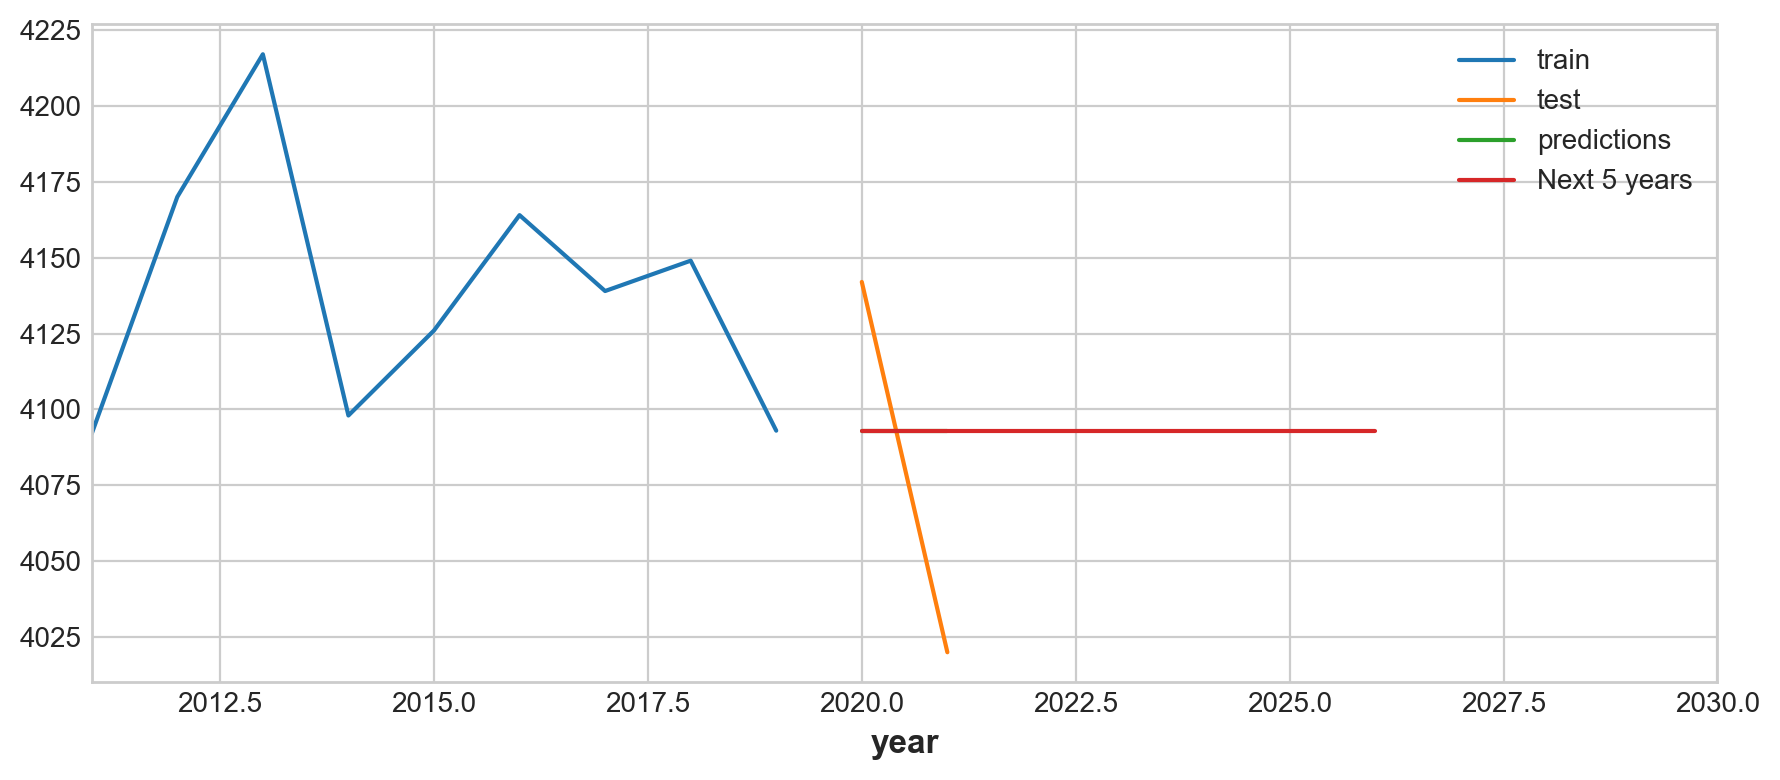

In [149]:
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train', xlim = (2011,2030))
data_test.plot(ax=ax, label='test', xlim = (2011,2030))
predictions.plot(ax=ax, label='predictions')
ahead_predictions.plot(ax=ax, label='Next 5 years')
ax.legend();

**EV**

In [150]:
ev = data.query('carType == "EV"').groupby(["year"], as_index=False).count()
ev.rename(columns={"carType": "count"}, inplace=True)
ev

,year,count
0,2011,3
1,2012,10
2,2013,21
3,2014,51
4,2015,53
5,2016,71
6,2017,59
7,2018,52
8,2019,98
9,2020,110


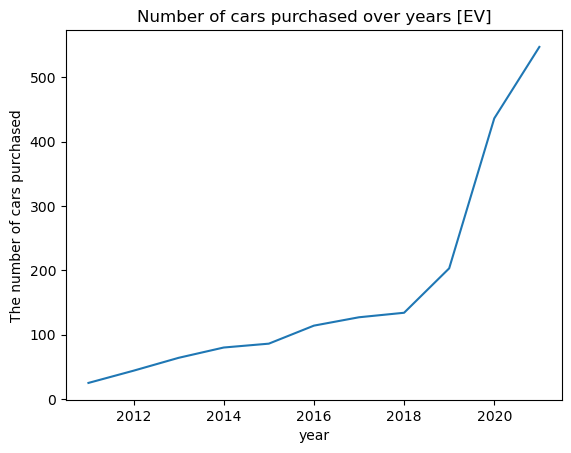

In [51]:
plt.title('Number of cars purchased over years [EV]')
plt.xlabel('year')
plt.ylabel('The number of cars purchased')
sns.lineplot(data=ev,x='year', y='count')
plt.show()

In [63]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) or (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [53]:
check_stationarity(ev["count"])

ADF Statistic: 1.288994
p-value: 0.996547
Critical Values:
	1%: -4.665
	5%: -3.367
	10%: -2.803
Non-stationary


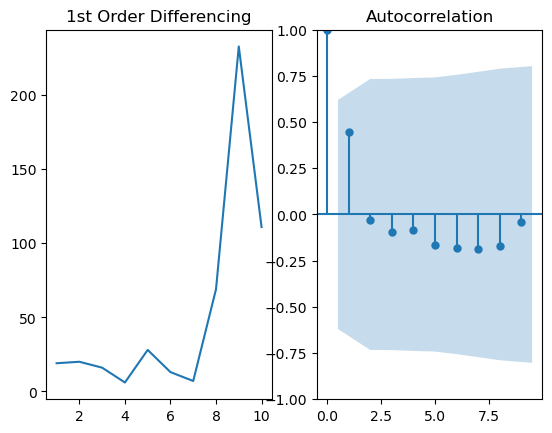

In [54]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(ev["count"].diff())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().dropna(), ax = ax2)
plt.show()

In [64]:
check_stationarity(ev["count"].diff().diff().dropna())

ADF Statistic: -3.186139
p-value: 0.020801
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
Stationary


c:\Users\harri\anaconda3\envs\dataScience\lib\site-packages\matplotlib\axes\_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


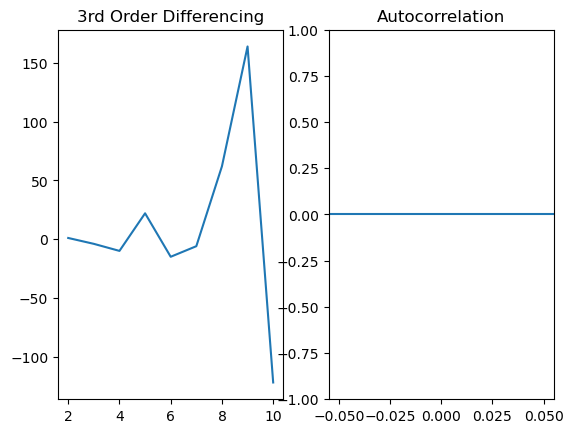

In [65]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("3rd Order Differencing")
ax1.plot(ev["count"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(ev["count"].diff().diff(), ax = ax2)
plt.show()

All EV cars are automatic, not manual. All EVs are automatic. EVs are power-efficient throughout their revs, unlike fuel engines which have a narrow rev band in which they can deliver maximum performance. EVs need only one gear.(based on https://www.rivervaleleasing.co.uk/guides/electric-vehicle-leasing/are-electric-cars-automatic-or-manual#:~:text=reach%20maximum%20torque.-,Are%20electric%20cars%20automatic%20or%20manual%3F,EVs%20need%20only%20one%20gear.)

However, there is a few companies started to invent EV cars with manual transmission and introduced it around 2022 and it is still new!! (based on https://www.motorbiscuit.com/electric-vehicles-manual-transmissions/ and https://robbreport.com/motors/cars/manual-transmission-electric-vehicles-future-1234774864/)

In [8]:
gear_data = dict(data["gear"].value_counts())
gear_data

{'Manual': 30309, 'Automatic': 15706, 'Semi-automatic': 56}

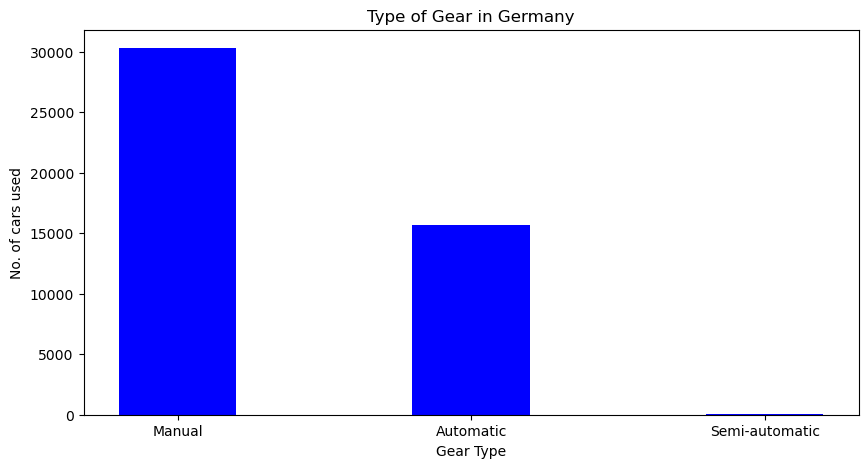

In [10]:
cat = list(gear_data.keys())
freq = list(gear_data.values())
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(cat, freq,color ='blue',
        width = 0.4, label = list(map(str,gear_data.values())))
 
plt.xlabel("Gear Type")
plt.ylabel("No. of cars used")
plt.title("Type of Gear in Germany")
plt.show()

Based on the bar chart, cars with manual transmission are two times bigger than cars with automatics and it is less amount of cars with semi-automatic.

In [61]:
#check data with manual gear type
data.query('gear =="Manual"')


,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011
...,...,...,...,...,...,...,...,...,...
46066,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46067,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46068,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46069,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [69]:
data["price"].min()

1100

In [62]:
data.query('gear =="Manual"')["fuel"].value_counts()

Gasoline             21804
Diesel                7922
Electric/Gasoline      301
LPG                    109
CNG                     95
Others                  37
-/- (Fuel)              16
Electric                16
Electric/Diesel          7
Ethanol                  2
Name: fuel, dtype: int64

Impossible! Records with manual gear should not have electric fuel.  

In [63]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline"')

,mileage,make,model,fuel,gear,offerType,price,hp,year
195,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10680,69.0,2021
197,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10980,69.0,2021
198,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10980,69.0,2021
394,9990,Ford,Fiesta,Electric/Gasoline,Manual,Employee's car,15970,125.0,2020
395,6315,Ford,Fiesta,Electric/Gasoline,Manual,Employee's car,16450,125.0,2020
...,...,...,...,...,...,...,...,...,...
46066,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46067,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46068,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46069,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [66]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')

,mileage,make,model,fuel,gear,offerType,price,hp,year
195,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10680,69.0,2021
197,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10980,69.0,2021
198,15,Fiat,Panda,Electric/Gasoline,Manual,Pre-registered,10980,69.0,2021
999,10,Fiat,500C,Electric/Gasoline,Manual,Pre-registered,15990,69.0,2021
1000,10,Fiat,500C,Electric/Gasoline,Manual,Pre-registered,15990,69.0,2021
...,...,...,...,...,...,...,...,...,...
46066,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46067,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46068,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46069,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [70]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')["offerType"].value_counts()

Pre-registered    134
Demonstration      23
Used                7
Name: offerType, dtype: int64

In [ ]:
data.query('gear =="Manual" & fuel =="Electric/Gasoline" & make =="Fiat"')["model"].value_counts()

In [60]:
#dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
temp2 = temp1.query('make=="Fiat" & model == "500"')
temp2

,mileage,make,model,fuel,gear,offerType,price,hp,year
1645,10,Fiat,500,Electric/Gasoline,Manual,Pre-registered,11488,69.0,2021
1836,15,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12780,69.0,2021
2647,1111,Fiat,500,Electric/Gasoline,Manual,Pre-registered,13090,69.0,2020
2648,1111,Fiat,500,Electric/Gasoline,Manual,Pre-registered,13090,69.0,2020
2649,1111,Fiat,500,Electric/Gasoline,Manual,Pre-registered,13090,69.0,2020
...,...,...,...,...,...,...,...,...,...
46066,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46067,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46068,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46069,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [44]:
manual_gear_data[manual_gear_data["fuel"]=="Electric/Gasoline"]["make"].value_counts()

Fiat          164
Ford           69
Suzuki         27
Hyundai        21
Mazda          14
Honda           4
Toyota          1
Volkswagen      1
Name: make, dtype: int64

In [30]:
fuel_feat = dict(data["fuel"].value_counts())
fuel_feat

{'Gasoline': 28720,
 'Diesel': 15178,
 'Electric/Gasoline': 1146,
 'Electric': 661,
 'LPG': 125,
 'CNG': 116,
 'Electric/Diesel': 53,
 'Others': 47,
 '-/- (Fuel)': 22,
 'Ethanol': 2,
 'Hydrogen': 1}

In [31]:
len(fuel_feat)

11

ICE - Gasoline, Diesel, LPG, CNG, Ethanol, Hydrogen, -/- (Fuel), 
EV - Electric/Gasoline, Electric, Electric/Diesel

In [33]:
temp_data = data[data["fuel"]=="Electric/Gasoline"]
temp_data

,mileage,make,model,fuel,gear,offerType,price,hp,year
5,147000,Toyota,Auris,Electric/Gasoline,Automatic,Used,6950,99.0,2011
63,84600,Toyota,Yaris,Electric/Gasoline,Automatic,Used,8990,143.0,2014
175,23490,Audi,A6,Electric/Gasoline,Automatic,Used,59440,367.0,2020
176,19000,Audi,Q5,Electric/Gasoline,Automatic,Demonstration,59850,367.0,2020
184,999,Audi,A7,Electric/Gasoline,Automatic,Used,66890,367.0,2020
...,...,...,...,...,...,...,...,...,...
46066,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46067,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46068,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46069,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [34]:
temp_data["gear"].value_counts()

Automatic    845
Manual       301
Name: gear, dtype: int64

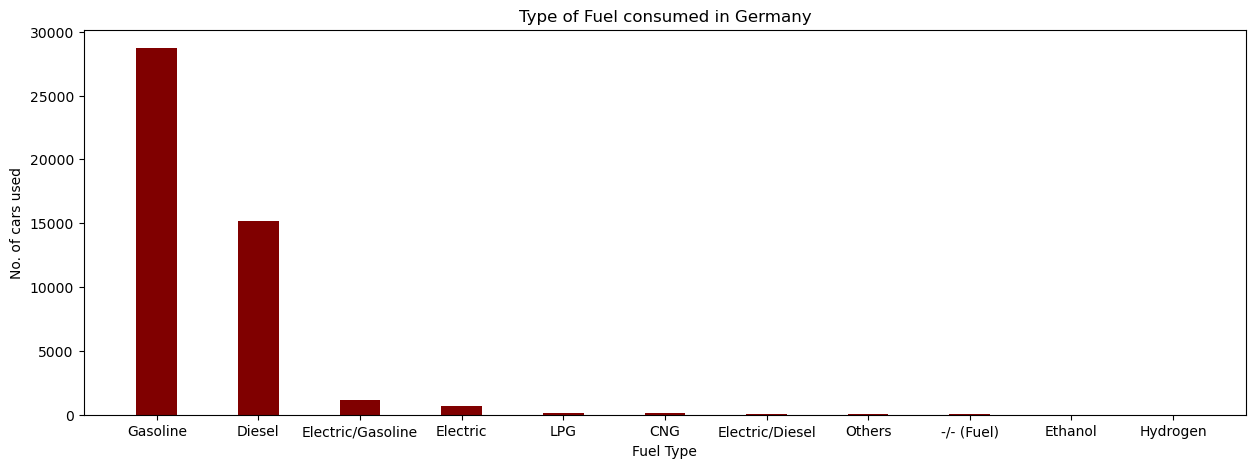

In [37]:
cat = list(fuel_feat.keys())
freq = list(fuel_feat.values())
fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(cat, freq,color ='maroon',
        width = 0.4, label = list(map(str,fuel_feat.values())))
 
plt.xlabel("Fuel Type")
plt.ylabel("No. of cars used")
plt.title("Type of Fuel consumed in Germany")
plt.show()

In [15]:
data["offerType"].value_counts()

Used              39822
Pre-registered     2768
Demonstration      2351
Employee's car     1117
New                  13
Name: offerType, dtype: int64

In [14]:
data["gear"].value_counts()

Manual            30309
Automatic         15706
Semi-automatic       56
Name: gear, dtype: int64